In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 3
2023-07-26 13:17:42.491971


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-9.1107)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(3.0174)
penalty_target_min tensor(-12.3234) penalty_target_max tensor(3.8660)
train_loss:  -10.667894838714599
valid_loss:  -10.686461560058595
h_min_tilde -12.323433 ell_tilde -10.671608182983398 kappa_tilde 0.0007780688288534831


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.1920928955078125e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.5028507709503174

 2 3.4028522968292236

 3 3.305079936981201

 4 3.2772905826568604

 5 3.4196135997772217

 6 3.1976406574249268

 7 3.1922662258148193

 8 3.3285984992980957

 9 3.211437702178955

 10 3.553834915161133

 11 4.17346978187561

 12 7.101741790771484

 13 6.873291730880737

 14 6.912736415863037

 15 6.776362895965576

 16 7.182206630706787

 17 3.4632980823516846

 18 3.291416883468628

 19 3.368783712387085

 20 3.4735324382781982

 21 3.383939266204834

 22 3.4066669940948486

 23 3.399432420730591

 24 3.394162178039551

 25 3.4906835556030273

 26 3.531289577484131

 27 3.436682939529419

 28 3.4278438091278076

 29 6.848031997680664

 30 6.8564512729644775

 31 7.1639955043792725

 32 6.901768207550049

 33 7.109194040298462

 34 6.741711616516113

 35 4.094973802566528

 36 3.382009267807007

 37 4.180286407470703

 38 7.050103425979614

 39 7.096980810165405

 40 7.207246780395508

 41 7.114142894744873

 42 4.951297998428345

 43 3.5197367668151855

 44 3

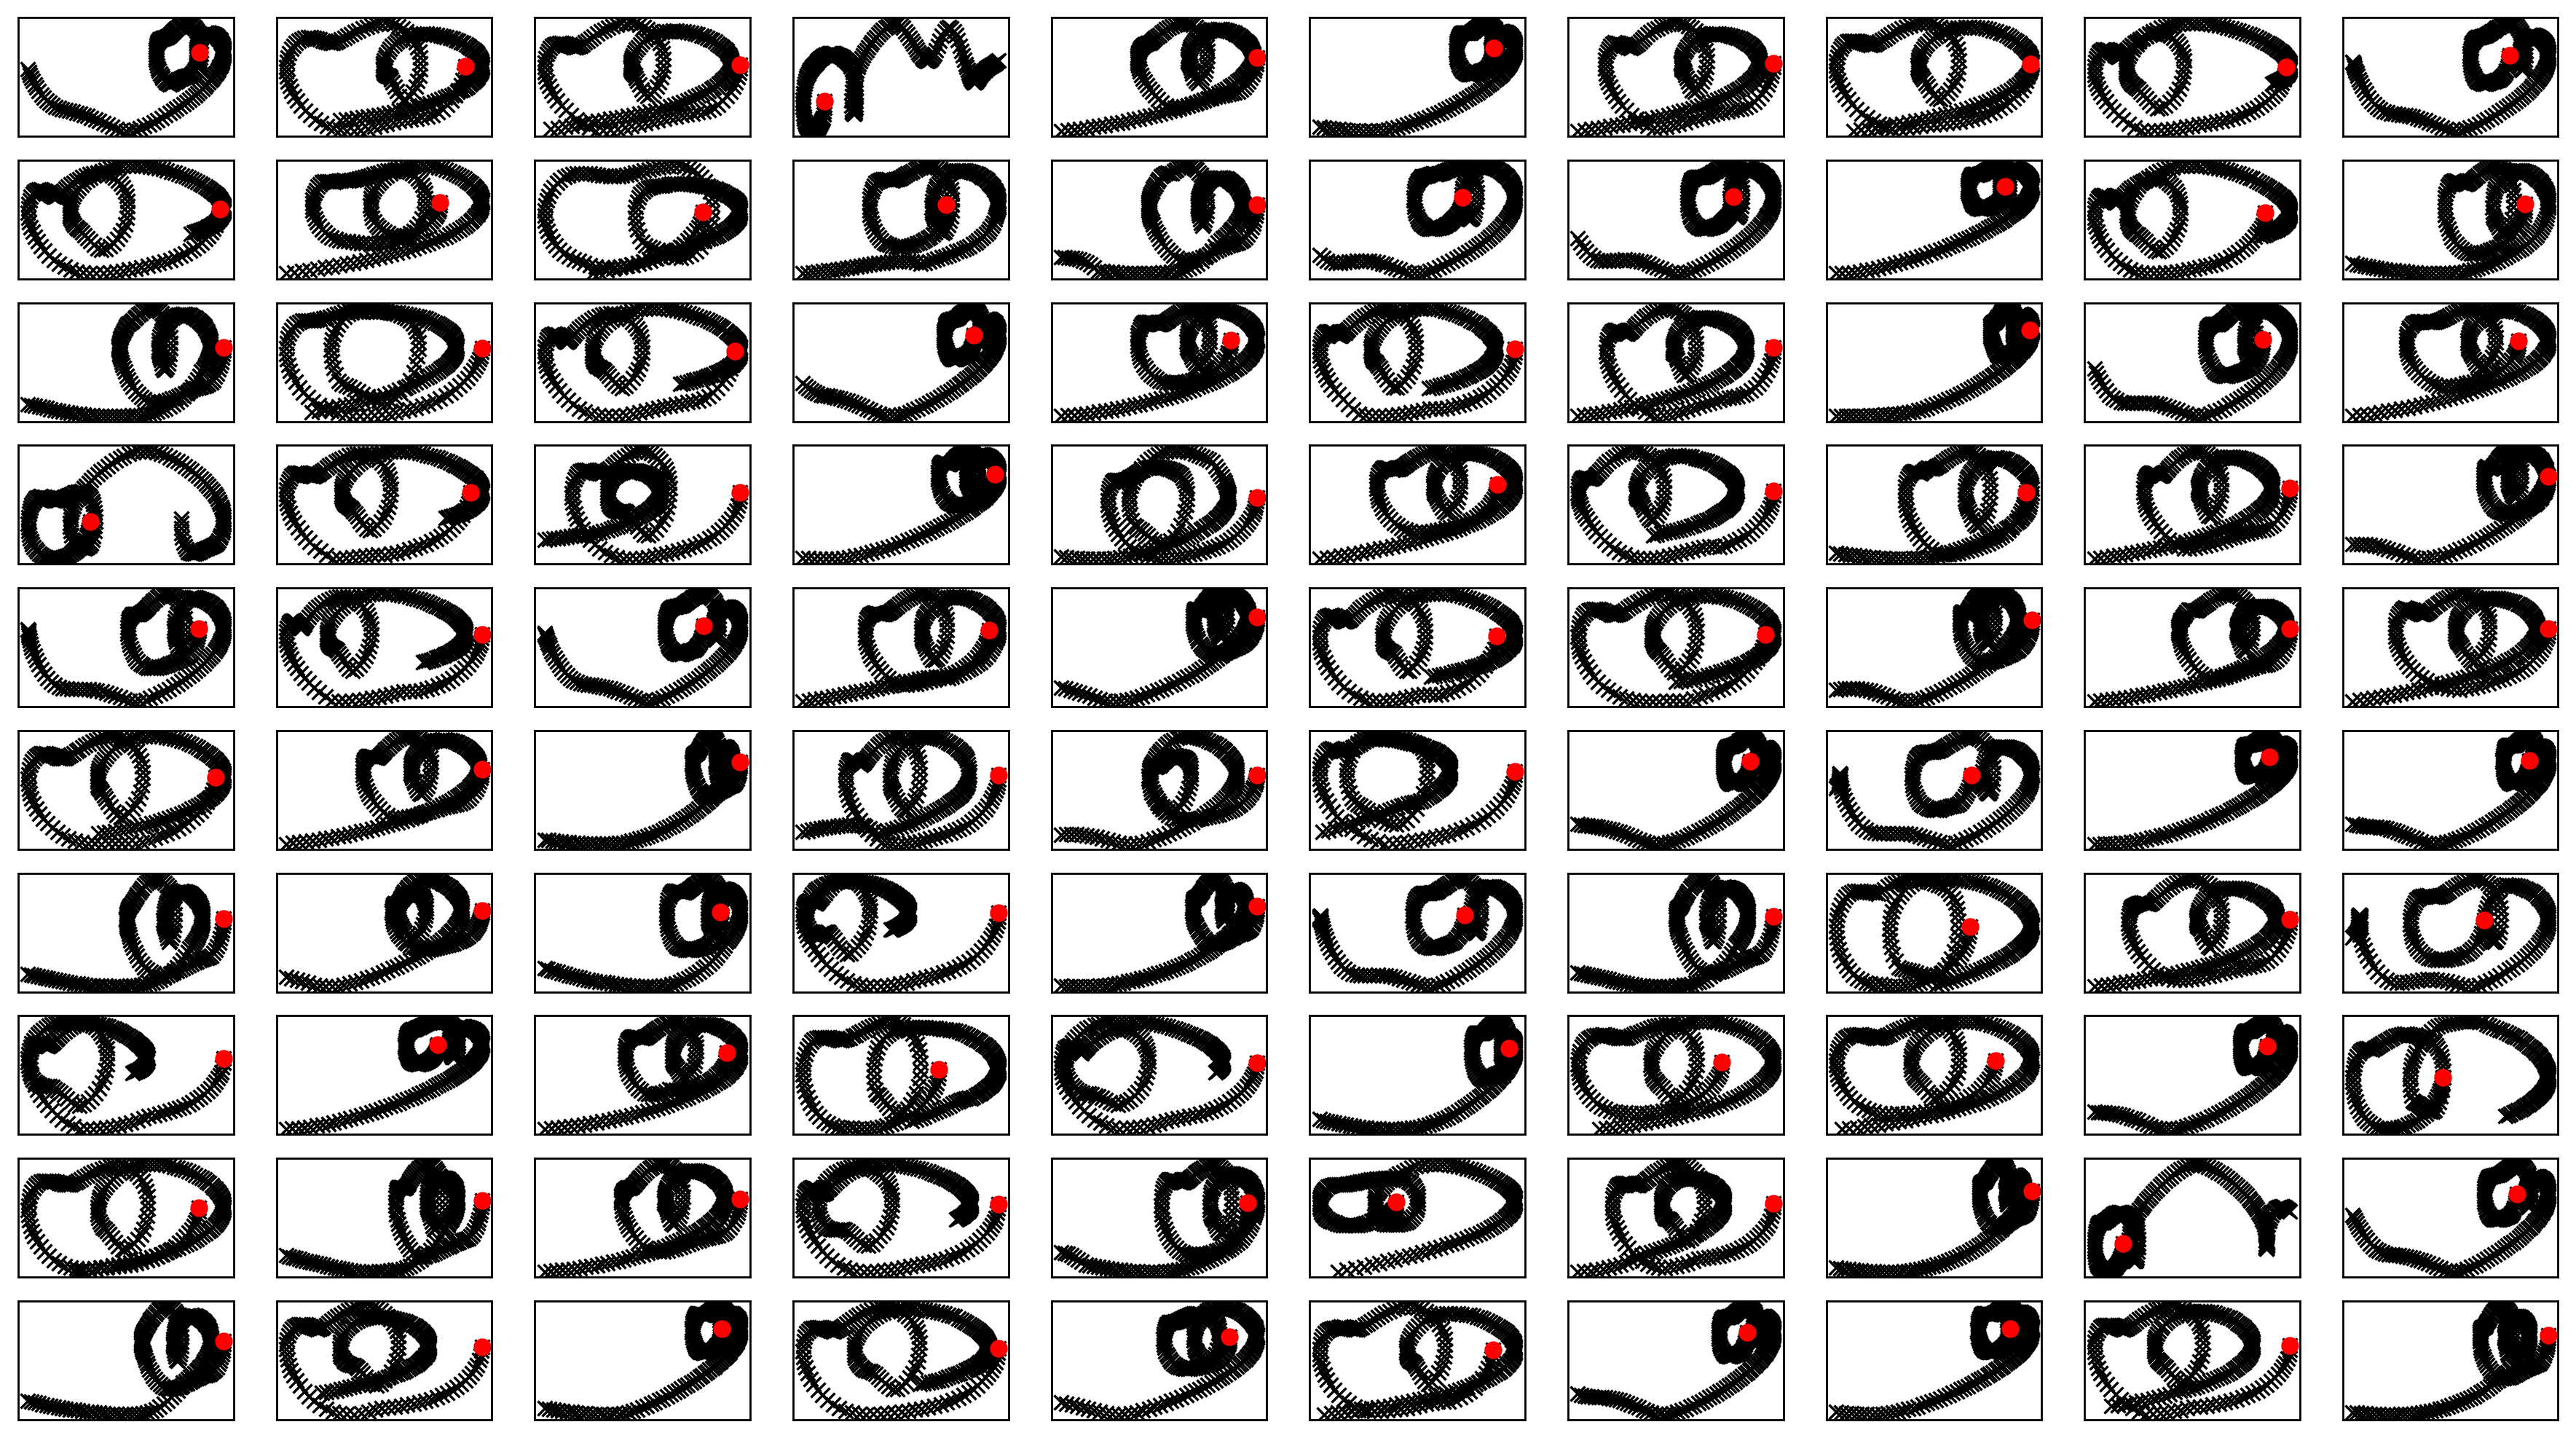

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

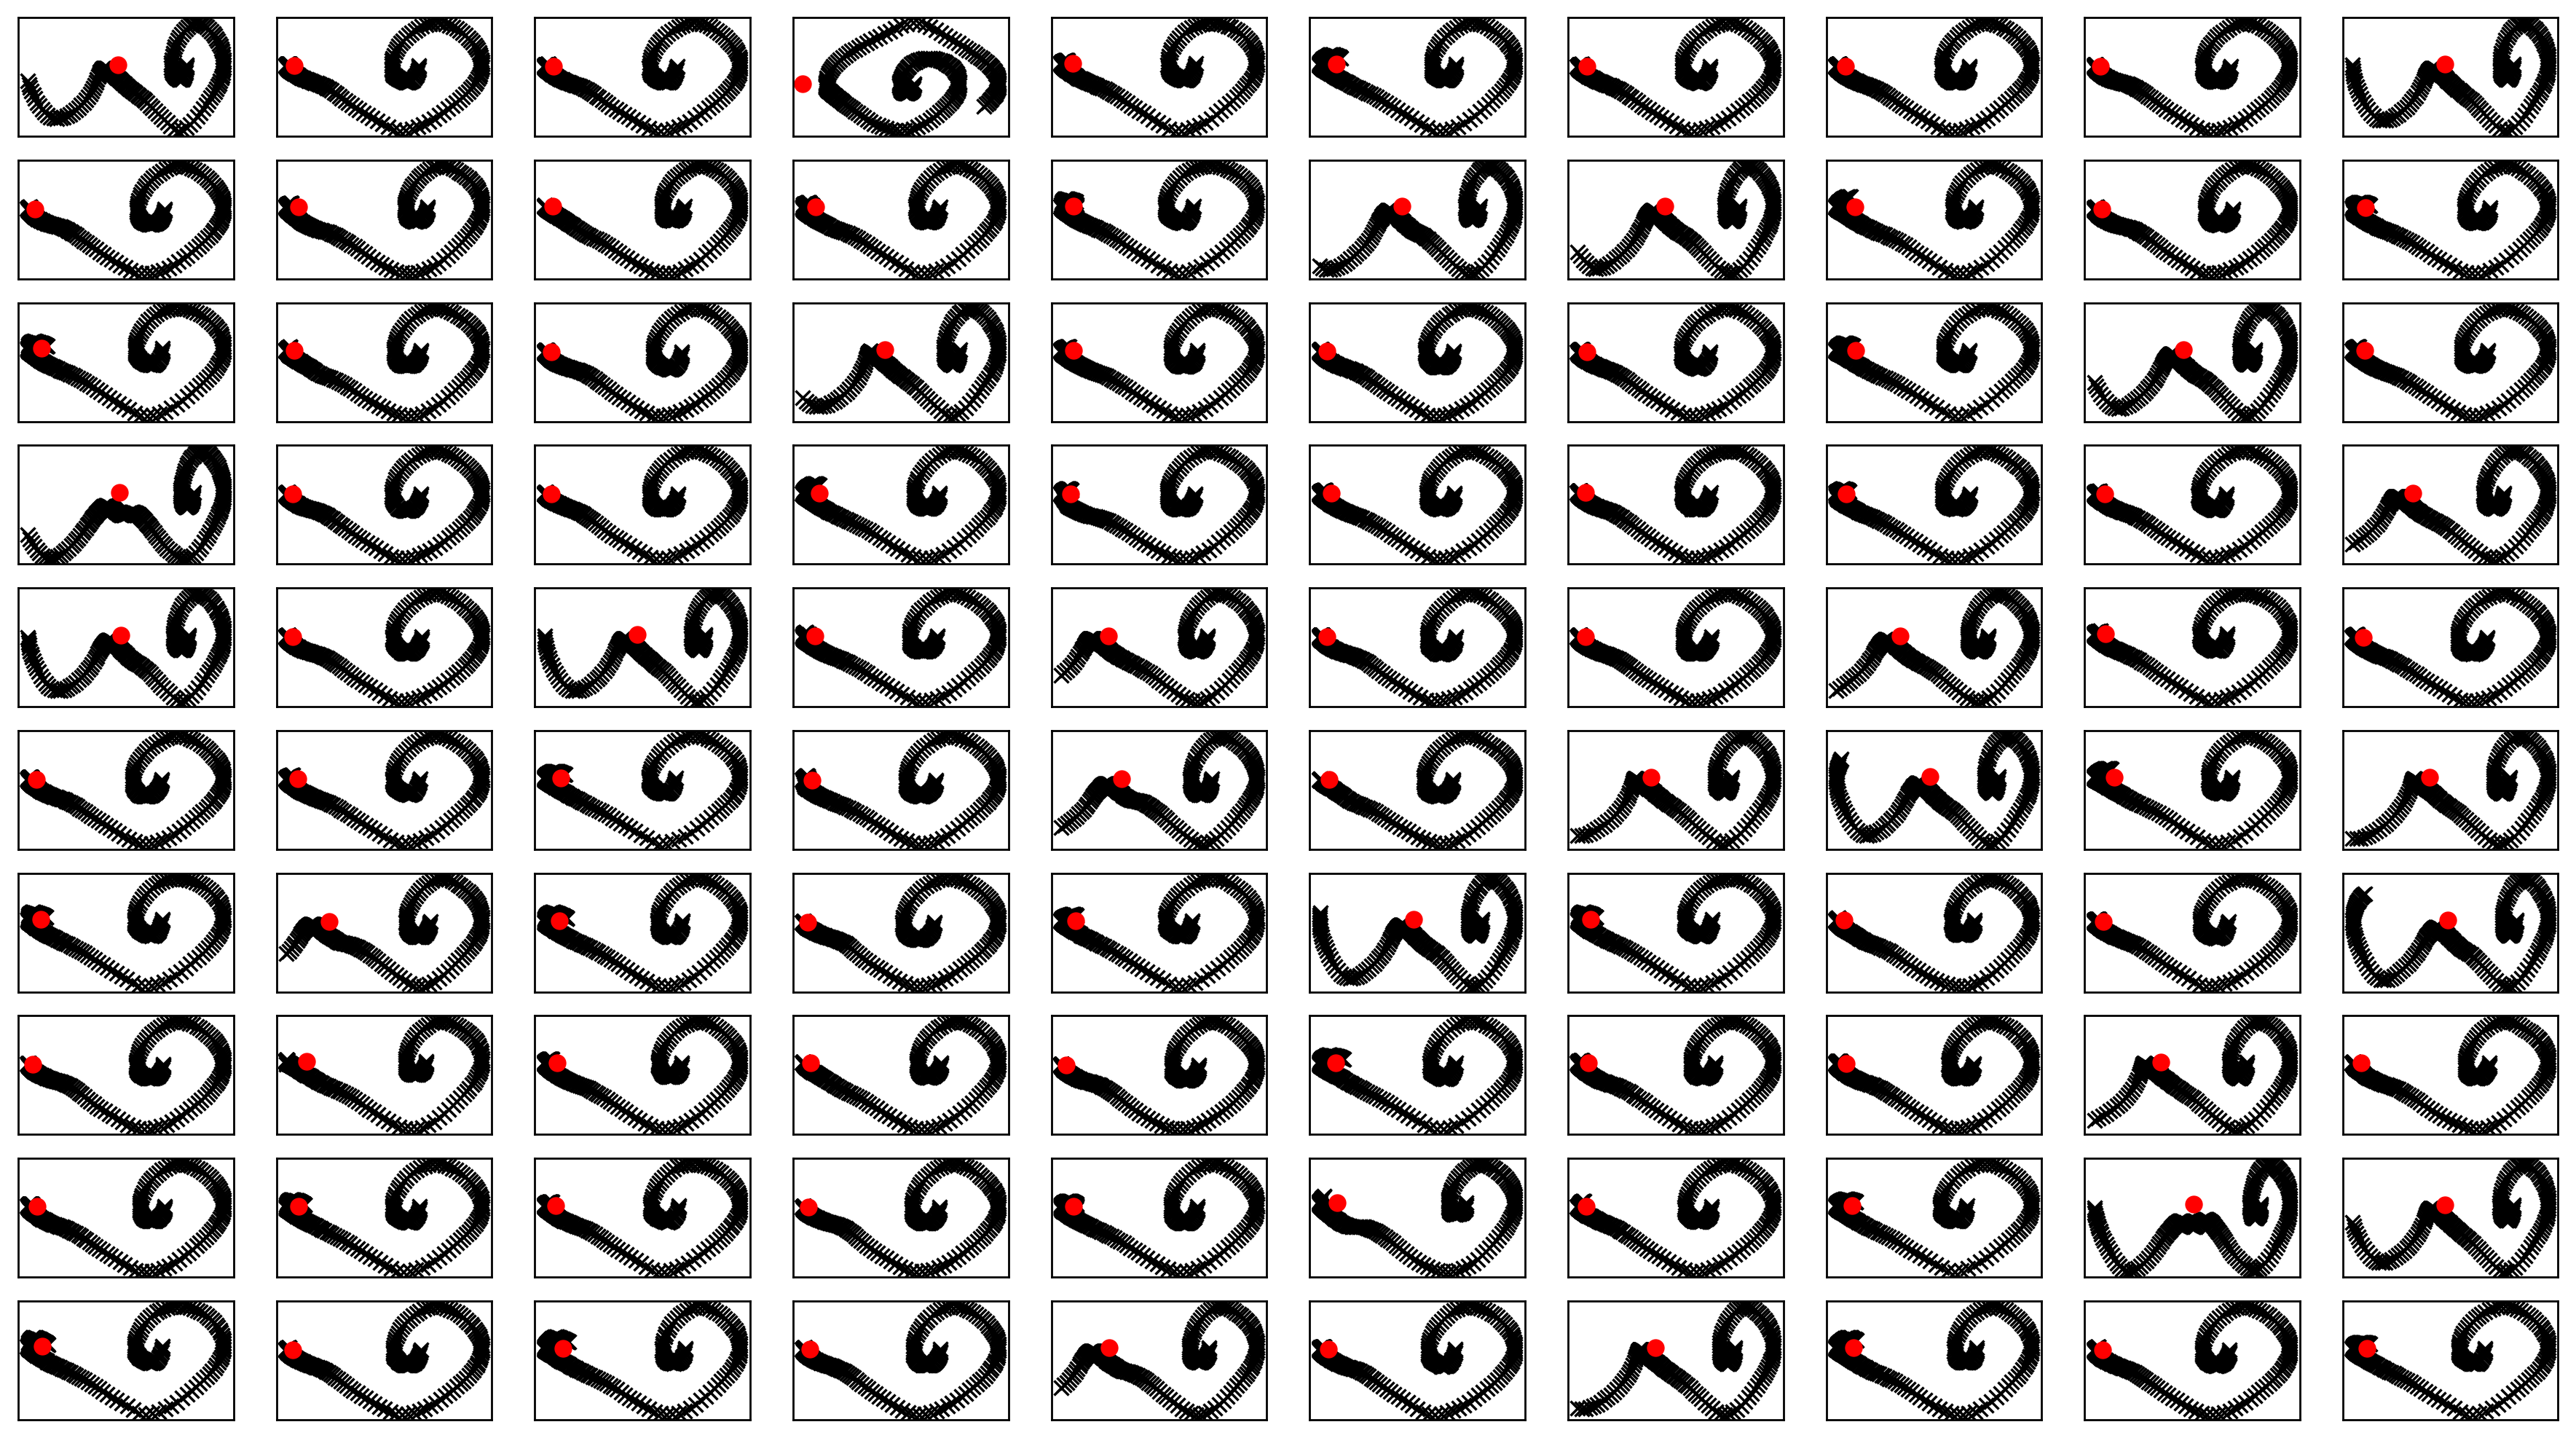

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-26 13:25:17.223079


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.38605  validloss 1.42667±0.00000  bestvalidloss 1.42667  last_update 0
train: iter 1  trainloss 1.34939  validloss 1.37277±0.00000  bestvalidloss 1.37277  last_update 0
train: iter 2  trainloss 1.32481  validloss 1.34815±0.00000  bestvalidloss 1.34815  last_update 0
train: iter 3  trainloss 1.30773  validloss 1.32653±0.00000  bestvalidloss 1.32653  last_update 0
train: iter 4  trainloss 1.29121  validloss 1.31688±0.00000  bestvalidloss 1.31688  last_update 0
train: iter 5  trainloss 1.27742  validloss 1.31333±0.00000  bestvalidloss 1.31333  last_update 0
train: iter 6  trainloss 1.26324  validloss 1.30851±0.00000  bestvalidloss 1.30851  last_update 0
train: iter 7  trainloss 1.24441  validloss 1.29921±0.00000  bestvalidloss 1.29921  last_update 0
train: iter 8  trainloss 1.22630  validloss 1.28474±0.00000  bestvalidloss 1.28474  last_update 0
train: iter 9  trainloss 1.20586  validloss 1.26569±0.00000  bestvalidloss 1.26569  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.80137  validloss 0.84355±0.00000  bestvalidloss 0.82053  last_update 10
train: iter 84  trainloss 0.80214  validloss 0.83798±0.00000  bestvalidloss 0.82053  last_update 11
train: iter 85  trainloss 0.79701  validloss 0.83068±0.00000  bestvalidloss 0.82053  last_update 12
train: iter 86  trainloss 0.79832  validloss 0.83300±0.00000  bestvalidloss 0.82053  last_update 13
train: iter 87  trainloss 0.79374  validloss 0.90348±0.00000  bestvalidloss 0.82053  last_update 14
train: iter 88  trainloss 0.79579  validloss 0.84118±0.00000  bestvalidloss 0.82053  last_update 15
train: iter 89  trainloss 0.79442  validloss 0.83535±0.00000  bestvalidloss 0.82053  last_update 16
train: iter 90  trainloss 0.80006  validloss 0.84982±0.00000  bestvalidloss 0.82053  last_update 17
train: iter 91  trainloss 0.78748  validloss 0.82817±0.00000  bestvalidloss 0.82053  last_update 18
train: iter 92  trainloss 0.78692  validloss 0.81596±0.00000  bestvalidloss 0.81596  last_update 0
t

train: iter 165  trainloss 0.73504  validloss 0.79360±0.00000  bestvalidloss 0.77048  last_update 2
train: iter 166  trainloss 0.74348  validloss 0.79965±0.00000  bestvalidloss 0.77048  last_update 3
train: iter 167  trainloss 0.73053  validloss 0.79167±0.00000  bestvalidloss 0.77048  last_update 4
train: iter 168  trainloss 0.72907  validloss 0.80605±0.00000  bestvalidloss 0.77048  last_update 5
train: iter 169  trainloss 0.74004  validloss 0.79025±0.00000  bestvalidloss 0.77048  last_update 6
train: iter 170  trainloss 0.73639  validloss 0.85704±0.00000  bestvalidloss 0.77048  last_update 7
train: iter 171  trainloss 0.72665  validloss 0.78584±0.00000  bestvalidloss 0.77048  last_update 8
train: iter 172  trainloss 0.72834  validloss 0.80225±0.00000  bestvalidloss 0.77048  last_update 9
train: iter 173  trainloss 0.72735  validloss 0.80302±0.00000  bestvalidloss 0.77048  last_update 10
train: iter 174  trainloss 0.72842  validloss 0.79687±0.00000  bestvalidloss 0.77048  last_update 1

train: iter 247  trainloss 0.69807  validloss 0.77575±0.00000  bestvalidloss 0.75651  last_update 41
train: iter 248  trainloss 0.70340  validloss 0.75331±0.00000  bestvalidloss 0.75331  last_update 0
train: iter 249  trainloss 0.69050  validloss 0.75746±0.00000  bestvalidloss 0.75331  last_update 1
train: iter 250  trainloss 0.70397  validloss 0.75681±0.00000  bestvalidloss 0.75331  last_update 2
train: iter 251  trainloss 0.69525  validloss 0.76835±0.00000  bestvalidloss 0.75331  last_update 3
train: iter 252  trainloss 0.69518  validloss 0.79032±0.00000  bestvalidloss 0.75331  last_update 4
train: iter 253  trainloss 0.69520  validloss 0.78976±0.00000  bestvalidloss 0.75331  last_update 5
train: iter 254  trainloss 0.69630  validloss 0.76834±0.00000  bestvalidloss 0.75331  last_update 6
train: iter 255  trainloss 0.69276  validloss 0.83134±0.00000  bestvalidloss 0.75331  last_update 7
train: iter 256  trainloss 0.69410  validloss 0.77377±0.00000  bestvalidloss 0.75331  last_update 8

train: iter 329  trainloss 0.65934  validloss 0.75428±0.00000  bestvalidloss 0.75302  last_update 46
train: iter 330  trainloss 0.67370  validloss 0.76965±0.00000  bestvalidloss 0.75302  last_update 47
train: iter 331  trainloss 0.68135  validloss 0.79131±0.00000  bestvalidloss 0.75302  last_update 48
train: iter 332  trainloss 0.67377  validloss 0.80435±0.00000  bestvalidloss 0.75302  last_update 49
train: iter 333  trainloss 0.66698  validloss 0.76484±0.00000  bestvalidloss 0.75302  last_update 50
train: iter 334  trainloss 0.68969  validloss 0.75898±0.00000  bestvalidloss 0.75302  last_update 51
train: iter 335  trainloss 0.67434  validloss 0.75012±0.00000  bestvalidloss 0.75012  last_update 0
train: iter 336  trainloss 0.65990  validloss 0.75037±0.00000  bestvalidloss 0.75012  last_update 1
train: iter 337  trainloss 0.67418  validloss 0.77547±0.00000  bestvalidloss 0.75012  last_update 2
train: iter 338  trainloss 0.66780  validloss 0.80522±0.00000  bestvalidloss 0.75012  last_upd

train: iter 411  trainloss 0.65457  validloss 0.75585±0.00000  bestvalidloss 0.73617  last_update 1
train: iter 412  trainloss 0.64262  validloss 0.75490±0.00000  bestvalidloss 0.73617  last_update 2
train: iter 413  trainloss 0.66045  validloss 0.75679±0.00000  bestvalidloss 0.73617  last_update 3
train: iter 414  trainloss 0.65252  validloss 0.77266±0.00000  bestvalidloss 0.73617  last_update 4
train: iter 415  trainloss 0.63947  validloss 0.77800±0.00000  bestvalidloss 0.73617  last_update 5
train: iter 416  trainloss 0.64362  validloss 0.77909±0.00000  bestvalidloss 0.73617  last_update 6
train: iter 417  trainloss 0.63927  validloss 0.75135±0.00000  bestvalidloss 0.73617  last_update 7
train: iter 418  trainloss 0.64705  validloss 0.78176±0.00000  bestvalidloss 0.73617  last_update 8
train: iter 419  trainloss 0.64724  validloss 0.80473±0.00000  bestvalidloss 0.73617  last_update 9
train: iter 420  trainloss 0.64729  validloss 0.82128±0.00000  bestvalidloss 0.73617  last_update 10

train: iter 493  trainloss 0.62471  validloss 0.77021±0.00000  bestvalidloss 0.73311  last_update 9
train: iter 494  trainloss 0.63824  validloss 0.77076±0.00000  bestvalidloss 0.73311  last_update 10
train: iter 495  trainloss 0.62374  validloss 0.74531±0.00000  bestvalidloss 0.73311  last_update 11
train: iter 496  trainloss 0.64301  validloss 0.78334±0.00000  bestvalidloss 0.73311  last_update 12
train: iter 497  trainloss 0.62620  validloss 0.74306±0.00000  bestvalidloss 0.73311  last_update 13
train: iter 498  trainloss 0.62890  validloss 0.78813±0.00000  bestvalidloss 0.73311  last_update 14
train: iter 499  trainloss 0.64003  validloss 0.84609±0.00000  bestvalidloss 0.73311  last_update 15
train: iter 500  trainloss 0.62214  validloss 0.75156±0.00000  bestvalidloss 0.73311  last_update 16
train: iter 501  trainloss 0.62272  validloss 0.74805±0.00000  bestvalidloss 0.73311  last_update 17
train: iter 502  trainloss 0.62762  validloss 0.76138±0.00000  bestvalidloss 0.73311  last_u

train: iter 575  trainloss 0.61164  validloss 0.74685±0.00000  bestvalidloss 0.72840  last_update 31
train: iter 576  trainloss 0.61259  validloss 0.77278±0.00000  bestvalidloss 0.72840  last_update 32
train: iter 577  trainloss 0.61591  validloss 0.73173±0.00000  bestvalidloss 0.72840  last_update 33
train: iter 578  trainloss 0.60730  validloss 0.76364±0.00000  bestvalidloss 0.72840  last_update 34
train: iter 579  trainloss 0.60372  validloss 0.74347±0.00000  bestvalidloss 0.72840  last_update 35
train: iter 580  trainloss 0.61072  validloss 0.74164±0.00000  bestvalidloss 0.72840  last_update 36
train: iter 581  trainloss 0.60890  validloss 0.73028±0.00000  bestvalidloss 0.72840  last_update 37
train: iter 582  trainloss 0.61513  validloss 0.76109±0.00000  bestvalidloss 0.72840  last_update 38
train: iter 583  trainloss 0.60817  validloss 0.73954±0.00000  bestvalidloss 0.72840  last_update 39
train: iter 584  trainloss 0.60647  validloss 0.74184±0.00000  bestvalidloss 0.72840  last_

train: iter 657  trainloss 0.60973  validloss 0.77878±0.00000  bestvalidloss 0.71483  last_update 26
train: iter 658  trainloss 0.60232  validloss 0.74607±0.00000  bestvalidloss 0.71483  last_update 27
train: iter 659  trainloss 0.59435  validloss 0.76219±0.00000  bestvalidloss 0.71483  last_update 28
train: iter 660  trainloss 0.59872  validloss 0.73658±0.00000  bestvalidloss 0.71483  last_update 29
train: iter 661  trainloss 0.60401  validloss 0.79183±0.00000  bestvalidloss 0.71483  last_update 30
train: iter 662  trainloss 0.58930  validloss 0.72760±0.00000  bestvalidloss 0.71483  last_update 31
train: iter 663  trainloss 0.59915  validloss 0.77094±0.00000  bestvalidloss 0.71483  last_update 32
train: iter 664  trainloss 0.59507  validloss 0.74847±0.00000  bestvalidloss 0.71483  last_update 33
train: iter 665  trainloss 0.59134  validloss 0.75122±0.00000  bestvalidloss 0.71483  last_update 34
train: iter 666  trainloss 0.59327  validloss 0.74079±0.00000  bestvalidloss 0.71483  last_

train: iter 739  trainloss 0.58596  validloss 0.75570±0.00000  bestvalidloss 0.69977  last_update 23
train: iter 740  trainloss 0.58391  validloss 0.73384±0.00000  bestvalidloss 0.69977  last_update 24
train: iter 741  trainloss 0.57689  validloss 0.74652±0.00000  bestvalidloss 0.69977  last_update 25
train: iter 742  trainloss 0.58870  validloss 0.72424±0.00000  bestvalidloss 0.69977  last_update 26
train: iter 743  trainloss 0.58359  validloss 0.72883±0.00000  bestvalidloss 0.69977  last_update 27
train: iter 744  trainloss 0.58604  validloss 0.73242±0.00000  bestvalidloss 0.69977  last_update 28
train: iter 745  trainloss 0.58554  validloss 0.75332±0.00000  bestvalidloss 0.69977  last_update 29
train: iter 746  trainloss 0.57292  validloss 0.71048±0.00000  bestvalidloss 0.69977  last_update 30
train: iter 747  trainloss 0.59252  validloss 0.74889±0.00000  bestvalidloss 0.69977  last_update 31
train: iter 748  trainloss 0.58437  validloss 0.70088±0.00000  bestvalidloss 0.69977  last_

train: iter 822  trainloss 0.56792  validloss 0.71518±0.00000  bestvalidloss 0.69476  last_update 15
train: iter 823  trainloss 0.57502  validloss 0.71965±0.00000  bestvalidloss 0.69476  last_update 16
train: iter 824  trainloss 0.56345  validloss 0.72206±0.00000  bestvalidloss 0.69476  last_update 17
train: iter 825  trainloss 0.56680  validloss 0.70461±0.00000  bestvalidloss 0.69476  last_update 18
train: iter 826  trainloss 0.56631  validloss 0.72345±0.00000  bestvalidloss 0.69476  last_update 19
train: iter 827  trainloss 0.56519  validloss 0.72671±0.00000  bestvalidloss 0.69476  last_update 20
train: iter 828  trainloss 0.57142  validloss 0.73633±0.00000  bestvalidloss 0.69476  last_update 21
train: iter 829  trainloss 0.56516  validloss 0.71209±0.00000  bestvalidloss 0.69476  last_update 22
train: iter 830  trainloss 0.56280  validloss 0.71768±0.00000  bestvalidloss 0.69476  last_update 23
train: iter 831  trainloss 0.56030  validloss 0.75160±0.00000  bestvalidloss 0.69476  last_

train: iter 904  trainloss 0.56219  validloss 0.71078±0.00000  bestvalidloss 0.68716  last_update 13
train: iter 905  trainloss 0.54696  validloss 0.70394±0.00000  bestvalidloss 0.68716  last_update 14
train: iter 906  trainloss 0.55658  validloss 0.73064±0.00000  bestvalidloss 0.68716  last_update 15
train: iter 907  trainloss 0.55095  validloss 0.74103±0.00000  bestvalidloss 0.68716  last_update 16
train: iter 908  trainloss 0.56009  validloss 0.70427±0.00000  bestvalidloss 0.68716  last_update 17
train: iter 909  trainloss 0.55106  validloss 0.68882±0.00000  bestvalidloss 0.68716  last_update 18
train: iter 910  trainloss 0.54841  validloss 0.72391±0.00000  bestvalidloss 0.68716  last_update 19
train: iter 911  trainloss 0.55346  validloss 0.71681±0.00000  bestvalidloss 0.68716  last_update 20
train: iter 912  trainloss 0.55098  validloss 0.71031±0.00000  bestvalidloss 0.68716  last_update 21
train: iter 913  trainloss 0.55134  validloss 0.72036±0.00000  bestvalidloss 0.68716  last_

train: iter 986  trainloss 0.54058  validloss 0.68689±0.00000  bestvalidloss 0.68002  last_update 61
train: iter 987  trainloss 0.53630  validloss 0.72584±0.00000  bestvalidloss 0.68002  last_update 62
train: iter 988  trainloss 0.53423  validloss 0.72995±0.00000  bestvalidloss 0.68002  last_update 63
train: iter 989  trainloss 0.53968  validloss 0.73794±0.00000  bestvalidloss 0.68002  last_update 64
train: iter 990  trainloss 0.54850  validloss 0.70636±0.00000  bestvalidloss 0.68002  last_update 65
train: iter 991  trainloss 0.53691  validloss 0.72253±0.00000  bestvalidloss 0.68002  last_update 66
train: iter 992  trainloss 0.54059  validloss 0.71502±0.00000  bestvalidloss 0.68002  last_update 67
train: iter 993  trainloss 0.54010  validloss 0.71296±0.00000  bestvalidloss 0.68002  last_update 68
train: iter 994  trainloss 0.55039  validloss 0.71493±0.00000  bestvalidloss 0.68002  last_update 69
train: iter 995  trainloss 0.53636  validloss 0.73015±0.00000  bestvalidloss 0.68002  last_

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

train_loss:  -6.15549697650671
valid_loss:  -10.362215174102783
weight_alpha 1.0 h_min_tilde -12.323433 ell_tilde -6.996840616025924 kappa_tilde 0.00043328661316752447
train_loss:  -7.1324478075027455
valid_loss:  -7.862011163330078
weight_alpha 0.1 h_min_tilde -12.323433 ell_tilde -7.278360478668212 kappa_tilde 0.0004452114208521916


In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1404.09140  validloss -1566.29097±0.00000  bestvalidloss -1566.29097  last_update 0
train: iter 1  trainloss -1398.08948  validloss -1529.42553±0.00000  bestvalidloss -1566.29097  last_update 1
train: iter 2  trainloss -1397.55306  validloss -1513.73799±0.00000  bestvalidloss -1566.29097  last_update 2
train: iter 3  trainloss -1403.50025  validloss -1512.11471±0.00000  bestvalidloss -1566.29097  last_update 3
train: iter 4  trainloss -1397.76899  validloss -1536.81758±0.00000  bestvalidloss -1566.29097  last_update 4
train: iter 5  trainloss -1409.66973  validloss -1507.86214±0.00000  bestvalidloss -1566.29097  last_update 5
train: iter 6  trainloss -1408.56513  validloss -1574.00921±0.00000  bestvalidloss -1574.00921  last_update 0
train: iter 7  trainloss -1402.91074  validloss -1536.40142±0.00000  bestvalidloss -1574.00921  last_update 1
train: iter 8  trainloss -1405.78412  validloss -1533.51388±0.00000  bestva

train: iter 74  trainloss -1453.33265  validloss -1573.16385±0.00000  bestvalidloss -1622.87114  last_update 5
train: iter 75  trainloss -1461.60834  validloss -1568.37785±0.00000  bestvalidloss -1622.87114  last_update 6
train: iter 76  trainloss -1467.09486  validloss -1628.03804±0.00000  bestvalidloss -1628.03804  last_update 0
train: iter 77  trainloss -1454.38058  validloss -1572.24603±0.00000  bestvalidloss -1628.03804  last_update 1
train: iter 78  trainloss -1438.67386  validloss -1619.25361±0.00000  bestvalidloss -1628.03804  last_update 2
train: iter 79  trainloss -1443.69346  validloss -1576.58344±0.00000  bestvalidloss -1628.03804  last_update 3
train: iter 80  trainloss -1459.56104  validloss -1581.23553±0.00000  bestvalidloss -1628.03804  last_update 4
train: iter 81  trainloss -1461.36258  validloss -1602.01152±0.00000  bestvalidloss -1628.03804  last_update 5
train: iter 82  trainloss -1461.57841  validloss -1584.30751±0.00000  bestvalidloss -1628.03804  last_update 6
t

train: iter 148  trainloss -1508.63444  validloss -1658.36715±0.00000  bestvalidloss -1673.65795  last_update 31
train: iter 149  trainloss -1505.10284  validloss -1670.05042±0.00000  bestvalidloss -1673.65795  last_update 32
train: iter 150  trainloss -1493.47369  validloss -1600.89662±0.00000  bestvalidloss -1673.65795  last_update 33
train: iter 151  trainloss -1500.05191  validloss -1541.58023±0.00000  bestvalidloss -1673.65795  last_update 34
train: iter 152  trainloss -1504.87012  validloss -1647.71518±0.00000  bestvalidloss -1673.65795  last_update 35
train: iter 153  trainloss -1517.37869  validloss -1682.15839±0.00000  bestvalidloss -1682.15839  last_update 0
train: iter 154  trainloss -1519.71934  validloss -1582.78601±0.00000  bestvalidloss -1682.15839  last_update 1
train: iter 155  trainloss -1507.63981  validloss -1625.95020±0.00000  bestvalidloss -1682.15839  last_update 2
train: iter 156  trainloss -1519.82270  validloss -1635.68150±0.00000  bestvalidloss -1682.15839  l

train: iter 221  trainloss -1582.84476  validloss -1694.74437±0.00000  bestvalidloss -1713.95250  last_update 2
train: iter 222  trainloss -1563.08859  validloss -1660.21385±0.00000  bestvalidloss -1713.95250  last_update 3
train: iter 223  trainloss -1569.39122  validloss -1677.78342±0.00000  bestvalidloss -1713.95250  last_update 4
train: iter 224  trainloss -1571.73330  validloss -1716.56074±0.00000  bestvalidloss -1716.56074  last_update 0
train: iter 225  trainloss -1582.56118  validloss -1691.24048±0.00000  bestvalidloss -1716.56074  last_update 1
train: iter 226  trainloss -1571.81732  validloss -1670.84590±0.00000  bestvalidloss -1716.56074  last_update 2
train: iter 227  trainloss -1567.57585  validloss -1660.82477±0.00000  bestvalidloss -1716.56074  last_update 3
train: iter 228  trainloss -1579.21062  validloss -1656.09233±0.00000  bestvalidloss -1716.56074  last_update 4
train: iter 229  trainloss -1574.23267  validloss -1705.45852±0.00000  bestvalidloss -1716.56074  last_u

train: iter 294  trainloss -1611.72764  validloss -1743.04565±0.00000  bestvalidloss -1752.87166  last_update 25
train: iter 295  trainloss -1609.93084  validloss -1677.66619±0.00000  bestvalidloss -1752.87166  last_update 26
train: iter 296  trainloss -1601.69235  validloss -1751.98380±0.00000  bestvalidloss -1752.87166  last_update 27
train: iter 297  trainloss -1608.04600  validloss -1679.38964±0.00000  bestvalidloss -1752.87166  last_update 28
train: iter 298  trainloss -1614.98657  validloss -1725.73778±0.00000  bestvalidloss -1752.87166  last_update 29
train: iter 299  trainloss -1593.98800  validloss -1727.41807±0.00000  bestvalidloss -1752.87166  last_update 30
train: iter 300  trainloss -1602.82174  validloss -1731.42561±0.00000  bestvalidloss -1752.87166  last_update 31
train: iter 301  trainloss -1602.85966  validloss -1750.24230±0.00000  bestvalidloss -1752.87166  last_update 32
train: iter 302  trainloss -1611.77816  validloss -1738.78354±0.00000  bestvalidloss -1752.87166

train: iter 367  trainloss -1669.24819  validloss -1759.71808±0.00000  bestvalidloss -1799.76740  last_update 30
train: iter 368  trainloss -1669.80251  validloss -1762.04659±0.00000  bestvalidloss -1799.76740  last_update 31
train: iter 369  trainloss -1664.41313  validloss -1735.06035±0.00000  bestvalidloss -1799.76740  last_update 32
train: iter 370  trainloss -1673.37241  validloss -1755.00626±0.00000  bestvalidloss -1799.76740  last_update 33
train: iter 371  trainloss -1674.40944  validloss -1781.73737±0.00000  bestvalidloss -1799.76740  last_update 34
train: iter 372  trainloss -1630.85337  validloss -1763.38531±0.00000  bestvalidloss -1799.76740  last_update 35
train: iter 373  trainloss -1683.52300  validloss -1750.76376±0.00000  bestvalidloss -1799.76740  last_update 36
train: iter 374  trainloss -1642.32569  validloss -1710.31328±0.00000  bestvalidloss -1799.76740  last_update 37
train: iter 375  trainloss -1674.10918  validloss -1775.19845±0.00000  bestvalidloss -1799.76740

train: iter 440  trainloss -1719.13089  validloss -1788.40297±0.00000  bestvalidloss -1821.33771  last_update 6
train: iter 441  trainloss -1696.92508  validloss -1780.88881±0.00000  bestvalidloss -1821.33771  last_update 7
train: iter 442  trainloss -1706.38815  validloss -1773.34984±0.00000  bestvalidloss -1821.33771  last_update 8
train: iter 443  trainloss -1703.48907  validloss -1766.88613±0.00000  bestvalidloss -1821.33771  last_update 9
train: iter 444  trainloss -1710.07414  validloss -1753.17209±0.00000  bestvalidloss -1821.33771  last_update 10
train: iter 445  trainloss -1711.47745  validloss -1825.65811±0.00000  bestvalidloss -1825.65811  last_update 0
train: iter 446  trainloss -1692.40726  validloss -1813.98194±0.00000  bestvalidloss -1825.65811  last_update 1
train: iter 447  trainloss -1706.78532  validloss -1797.32838±0.00000  bestvalidloss -1825.65811  last_update 2
train: iter 448  trainloss -1715.65909  validloss -1814.56690±0.00000  bestvalidloss -1825.65811  last_

train: iter 513  trainloss -1756.35174  validloss -1808.54460±0.00000  bestvalidloss -1844.33422  last_update 2
train: iter 514  trainloss -1752.31356  validloss -1812.66725±0.00000  bestvalidloss -1844.33422  last_update 3
train: iter 515  trainloss -1757.68077  validloss -1828.59835±0.00000  bestvalidloss -1844.33422  last_update 4
train: iter 516  trainloss -1749.95830  validloss -1750.96767±0.00000  bestvalidloss -1844.33422  last_update 5
train: iter 517  trainloss -1763.45260  validloss -1799.84440±0.00000  bestvalidloss -1844.33422  last_update 6
train: iter 518  trainloss -1759.20712  validloss -1803.77443±0.00000  bestvalidloss -1844.33422  last_update 7
train: iter 519  trainloss -1752.55373  validloss -1800.90208±0.00000  bestvalidloss -1844.33422  last_update 8
train: iter 520  trainloss -1749.71052  validloss -1839.30370±0.00000  bestvalidloss -1844.33422  last_update 9
train: iter 521  trainloss -1705.38979  validloss -1799.50964±0.00000  bestvalidloss -1844.33422  last_u

train: iter 586  trainloss -1790.67715  validloss -1817.65249±0.00000  bestvalidloss -1872.09941  last_update 17
train: iter 587  trainloss -1780.73135  validloss -1830.19061±0.00000  bestvalidloss -1872.09941  last_update 18
train: iter 588  trainloss -1761.28418  validloss -1813.50672±0.00000  bestvalidloss -1872.09941  last_update 19
train: iter 589  trainloss -1778.57859  validloss -1865.68435±0.00000  bestvalidloss -1872.09941  last_update 20
train: iter 590  trainloss -1771.33677  validloss -1854.55751±0.00000  bestvalidloss -1872.09941  last_update 21
train: iter 591  trainloss -1787.72179  validloss -1826.70273±0.00000  bestvalidloss -1872.09941  last_update 22
train: iter 592  trainloss -1798.51731  validloss -1869.38387±0.00000  bestvalidloss -1872.09941  last_update 23
train: iter 593  trainloss -1794.72055  validloss -1848.73814±0.00000  bestvalidloss -1872.09941  last_update 24
train: iter 594  trainloss -1791.15170  validloss -1865.93075±0.00000  bestvalidloss -1872.09941

train: iter 659  trainloss -1819.69536  validloss -1876.49326±0.00000  bestvalidloss -1897.99091  last_update 36
train: iter 660  trainloss -1832.64610  validloss -1907.94001±0.00000  bestvalidloss -1907.94001  last_update 0
train: iter 661  trainloss -1832.70689  validloss -1848.20107±0.00000  bestvalidloss -1907.94001  last_update 1
train: iter 662  trainloss -1830.12214  validloss -1832.88449±0.00000  bestvalidloss -1907.94001  last_update 2
train: iter 663  trainloss -1822.49349  validloss -1863.28647±0.00000  bestvalidloss -1907.94001  last_update 3
train: iter 664  trainloss -1808.11218  validloss -1838.44362±0.00000  bestvalidloss -1907.94001  last_update 4
train: iter 665  trainloss -1817.75310  validloss -1879.47522±0.00000  bestvalidloss -1907.94001  last_update 5
train: iter 666  trainloss -1821.76635  validloss -1861.81951±0.00000  bestvalidloss -1907.94001  last_update 6
train: iter 667  trainloss -1791.16213  validloss -1870.95476±0.00000  bestvalidloss -1907.94001  last_

train: iter 732  trainloss -1850.46500  validloss -1857.98181±0.00000  bestvalidloss -1925.43165  last_update 20
train: iter 733  trainloss -1860.90944  validloss -1871.25952±0.00000  bestvalidloss -1925.43165  last_update 21
train: iter 734  trainloss -1852.25420  validloss -1890.98281±0.00000  bestvalidloss -1925.43165  last_update 22
train: iter 735  trainloss -1833.92698  validloss -1868.00766±0.00000  bestvalidloss -1925.43165  last_update 23
train: iter 736  trainloss -1847.66348  validloss -1868.07843±0.00000  bestvalidloss -1925.43165  last_update 24
train: iter 737  trainloss -1852.01090  validloss -1903.84777±0.00000  bestvalidloss -1925.43165  last_update 25
train: iter 738  trainloss -1842.50746  validloss -1815.22470±0.00000  bestvalidloss -1925.43165  last_update 26
train: iter 739  trainloss -1852.03121  validloss -1884.85878±0.00000  bestvalidloss -1925.43165  last_update 27
train: iter 740  trainloss -1868.68074  validloss -1896.96852±0.00000  bestvalidloss -1925.43165

train: iter 805  trainloss -1886.96706  validloss -1916.18669±0.00000  bestvalidloss -1965.61335  last_update 28
train: iter 806  trainloss -1885.65119  validloss -1893.09303±0.00000  bestvalidloss -1965.61335  last_update 29
train: iter 807  trainloss -1879.88357  validloss -1856.14919±0.00000  bestvalidloss -1965.61335  last_update 30
train: iter 808  trainloss -1888.74075  validloss -1947.78876±0.00000  bestvalidloss -1965.61335  last_update 31
train: iter 809  trainloss -1867.98958  validloss -1931.20032±0.00000  bestvalidloss -1965.61335  last_update 32
train: iter 810  trainloss -1847.39493  validloss -1926.82554±0.00000  bestvalidloss -1965.61335  last_update 33
train: iter 811  trainloss -1811.71177  validloss -1736.37607±0.00000  bestvalidloss -1965.61335  last_update 34
train: iter 812  trainloss -1880.01122  validloss -1964.96416±0.00000  bestvalidloss -1965.61335  last_update 35
train: iter 813  trainloss -1888.64174  validloss -1948.26171±0.00000  bestvalidloss -1965.61335

train: iter 878  trainloss -1848.15678  validloss -1856.41277±0.00000  bestvalidloss -1976.47033  last_update 16
train: iter 879  trainloss -1880.31836  validloss -1896.97493±0.00000  bestvalidloss -1976.47033  last_update 17
train: iter 880  trainloss -1917.32920  validloss -1929.49768±0.00000  bestvalidloss -1976.47033  last_update 18
train: iter 881  trainloss -1913.46938  validloss -1955.17480±0.00000  bestvalidloss -1976.47033  last_update 19
train: iter 882  trainloss -1894.11476  validloss -1930.64671±0.00000  bestvalidloss -1976.47033  last_update 20
train: iter 883  trainloss -1913.09799  validloss -1876.42716±0.00000  bestvalidloss -1976.47033  last_update 21
train: iter 884  trainloss -1904.67439  validloss -1931.28658±0.00000  bestvalidloss -1976.47033  last_update 22
train: iter 885  trainloss -1898.49283  validloss -1903.88537±0.00000  bestvalidloss -1976.47033  last_update 23
train: iter 886  trainloss -1891.53085  validloss -1928.30125±0.00000  bestvalidloss -1976.47033

train: iter 951  trainloss -1924.33932  validloss -1937.68185±0.00000  bestvalidloss -1987.69029  last_update 34
train: iter 952  trainloss -1911.38188  validloss -1922.45384±0.00000  bestvalidloss -1987.69029  last_update 35
train: iter 953  trainloss -1915.24487  validloss -1932.33426±0.00000  bestvalidloss -1987.69029  last_update 36
train: iter 954  trainloss -1919.63825  validloss -1968.77682±0.00000  bestvalidloss -1987.69029  last_update 37
train: iter 955  trainloss -1900.91324  validloss -1895.86668±0.00000  bestvalidloss -1987.69029  last_update 38
train: iter 956  trainloss -1822.79511  validloss -1925.28874±0.00000  bestvalidloss -1987.69029  last_update 39
train: iter 957  trainloss -1915.52593  validloss -1922.94332±0.00000  bestvalidloss -1987.69029  last_update 40
train: iter 958  trainloss -1924.79494  validloss -1940.36802±0.00000  bestvalidloss -1987.69029  last_update 41
train: iter 959  trainloss -1934.71119  validloss -1949.28186±0.00000  bestvalidloss -1987.69029

train: iter 1024  trainloss -1938.27930  validloss -1966.65543±0.00000  bestvalidloss -1991.25533  last_update 64
train: iter 1025  trainloss -1909.16877  validloss -1940.44079±0.00000  bestvalidloss -1991.25533  last_update 65
train: iter 1026  trainloss -1911.30251  validloss -1957.12568±0.00000  bestvalidloss -1991.25533  last_update 66
train: iter 1027  trainloss -1921.65519  validloss -1878.49503±0.00000  bestvalidloss -1991.25533  last_update 67
train: iter 1028  trainloss -1944.93238  validloss -1938.59858±0.00000  bestvalidloss -1991.25533  last_update 68
train: iter 1029  trainloss -1936.00557  validloss -1931.17091±0.00000  bestvalidloss -1991.25533  last_update 69
train: iter 1030  trainloss -1918.77647  validloss -1945.08658±0.00000  bestvalidloss -1991.25533  last_update 70
train: iter 1031  trainloss -1929.57105  validloss -1934.39485±0.00000  bestvalidloss -1991.25533  last_update 71
train: iter 1032  trainloss -1924.57832  validloss -1932.64873±0.00000  bestvalidloss -1

train: iter 1096  trainloss -1940.48193  validloss -2000.27350±0.00000  bestvalidloss -2003.60777  last_update 49
train: iter 1097  trainloss -1927.29748  validloss -1965.64714±0.00000  bestvalidloss -2003.60777  last_update 50
train: iter 1098  trainloss -1935.44328  validloss -1970.01898±0.00000  bestvalidloss -2003.60777  last_update 51
train: iter 1099  trainloss -1930.85466  validloss -1967.76282±0.00000  bestvalidloss -2003.60777  last_update 52
train: iter 1100  trainloss -1925.17429  validloss -1976.96539±0.00000  bestvalidloss -2003.60777  last_update 53
train: iter 1101  trainloss -1943.14240  validloss -1957.81158±0.00000  bestvalidloss -2003.60777  last_update 54
train: iter 1102  trainloss -1927.64113  validloss -1915.85023±0.00000  bestvalidloss -2003.60777  last_update 55
train: iter 1103  trainloss -1930.08370  validloss -1950.27849±0.00000  bestvalidloss -2003.60777  last_update 56
train: iter 1104  trainloss -1934.44286  validloss -1947.14191±0.00000  bestvalidloss -2

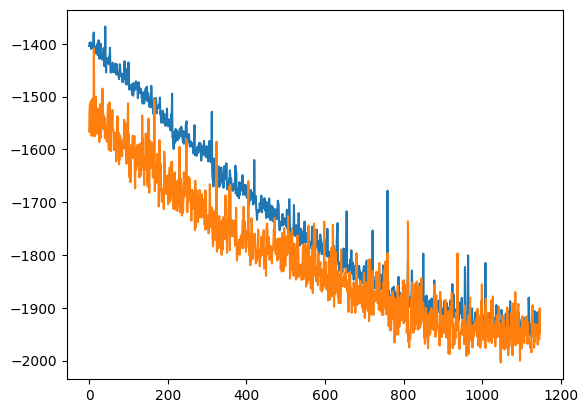

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-26 13:56:21.475149


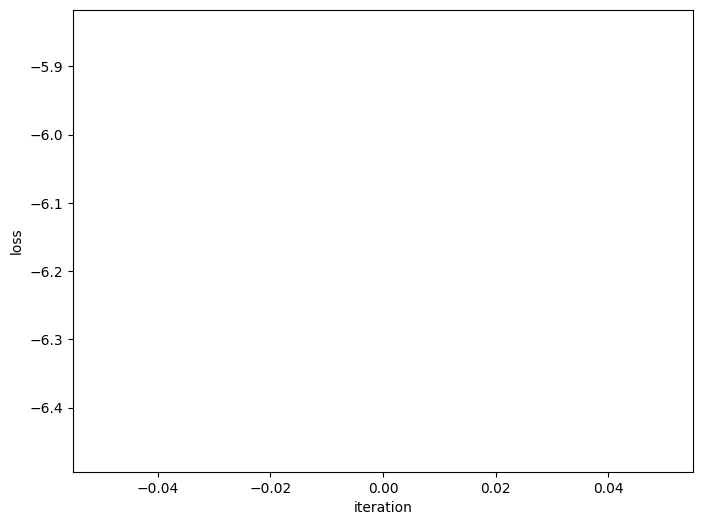

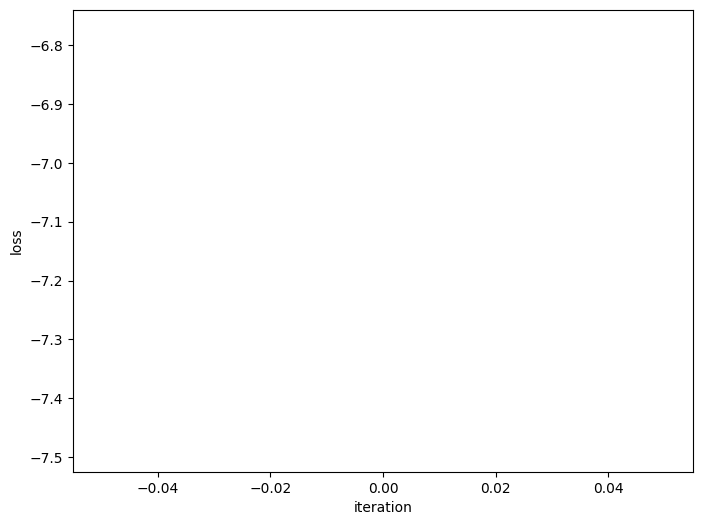

# Iter2

In [18]:
policy_evaluation_iter=1

In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27
predict diverge [ 3.93275324  8.89610978 -0.44566142 -1.12557518] [ 0.07122373  0.13094075 -0.0598162  -0.05979679] [17.259445  8.767078 53.96649  22.62447 ] [ 8.629723  4.383539 26.983246 11.312235] sim_timestep 66

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77
predict diverge [ 0.90000841 -8.85241761 25.50744547 -8.37057071] [-0.06249343 -0.24841905 -0.09411034 -0.7251937 ] [17.259445  8.767078 53.96649  22.62447 ] [ 8.629723  4.383539 26.983246 11.312235] sim_timestep 176

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.48181  validloss 1.74158±0.00000  bestvalidloss 1.74158  last_update 0
train: iter 1  trainloss 1.16399  validloss 1.16141±0.00000  bestvalidloss 1.16141  last_update 0
train: iter 2  trainloss 1.02939  validloss 0.91187±0.00000  bestvalidloss 0.91187  last_update 0
train: iter 3  trainloss 0.97557  validloss 0.85756±0.00000  bestvalidloss 0.85756  last_update 0
train: iter 4  trainloss 0.94722  validloss 0.85766±0.00000  bestvalidloss 0.85756  last_update 1
train: iter 5  trainloss 0.91905  validloss 0.83239±0.00000  bestvalidloss 0.83239  last_update 0
train: iter 6  trainloss 0.91661  validloss 0.82583±0.00000  bestvalidloss 0.82583  last_update 0
train: iter 7  trainloss 0.88654  validloss 0.82034±0.00000  bestvalidloss 0.82034  last_update 0
train: iter 8  trainloss 0.87746  validloss 0.81255±0.00000  bestvalidloss 0.81255  last_update 0
train: iter 9  trainloss 0.87274  validloss 0.79759±0.00000  bestvalidloss 0.79759  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.70621  validloss 0.77289±0.00000  bestvalidloss 0.75292  last_update 36
train: iter 84  trainloss 0.69981  validloss 0.75232±0.00000  bestvalidloss 0.75232  last_update 0
train: iter 85  trainloss 0.70519  validloss 0.76293±0.00000  bestvalidloss 0.75232  last_update 1
train: iter 86  trainloss 0.70652  validloss 0.78927±0.00000  bestvalidloss 0.75232  last_update 2
train: iter 87  trainloss 0.70072  validloss 0.76767±0.00000  bestvalidloss 0.75232  last_update 3
train: iter 88  trainloss 0.70780  validloss 0.79523±0.00000  bestvalidloss 0.75232  last_update 4
train: iter 89  trainloss 0.70425  validloss 0.78612±0.00000  bestvalidloss 0.75232  last_update 5
train: iter 90  trainloss 0.70347  validloss 0.78136±0.00000  bestvalidloss 0.75232  last_update 6
train: iter 91  trainloss 0.70412  validloss 0.73716±0.00000  bestvalidloss 0.73716  last_update 0
train: iter 92  trainloss 0.70963  validloss 0.76502±0.00000  bestvalidloss 0.73716  last_update 1
train: it

train: iter 165  trainloss 0.66878  validloss 0.75733±0.00000  bestvalidloss 0.73611  last_update 18
train: iter 166  trainloss 0.67419  validloss 0.73731±0.00000  bestvalidloss 0.73611  last_update 19
train: iter 167  trainloss 0.66291  validloss 0.73971±0.00000  bestvalidloss 0.73611  last_update 20
train: iter 168  trainloss 0.67170  validloss 0.75759±0.00000  bestvalidloss 0.73611  last_update 21
train: iter 169  trainloss 0.66754  validloss 0.77661±0.00000  bestvalidloss 0.73611  last_update 22
train: iter 170  trainloss 0.66018  validloss 0.77203±0.00000  bestvalidloss 0.73611  last_update 23
train: iter 171  trainloss 0.66654  validloss 0.76784±0.00000  bestvalidloss 0.73611  last_update 24
train: iter 172  trainloss 0.65713  validloss 0.76999±0.00000  bestvalidloss 0.73611  last_update 25
train: iter 173  trainloss 0.66768  validloss 0.77075±0.00000  bestvalidloss 0.73611  last_update 26
train: iter 174  trainloss 0.66169  validloss 0.76606±0.00000  bestvalidloss 0.73611  last_

train: iter 247  trainloss 0.63629  validloss 0.76394±0.00000  bestvalidloss 0.71659  last_update 45
train: iter 248  trainloss 0.63519  validloss 0.76801±0.00000  bestvalidloss 0.71659  last_update 46
train: iter 249  trainloss 0.63118  validloss 0.72383±0.00000  bestvalidloss 0.71659  last_update 47
train: iter 250  trainloss 0.64410  validloss 0.75604±0.00000  bestvalidloss 0.71659  last_update 48
train: iter 251  trainloss 0.64110  validloss 0.78969±0.00000  bestvalidloss 0.71659  last_update 49
train: iter 252  trainloss 0.63728  validloss 0.74708±0.00000  bestvalidloss 0.71659  last_update 50
train: iter 253  trainloss 0.63632  validloss 0.76169±0.00000  bestvalidloss 0.71659  last_update 51
train: iter 254  trainloss 0.63940  validloss 0.75234±0.00000  bestvalidloss 0.71659  last_update 52
train: iter 255  trainloss 0.63301  validloss 0.73519±0.00000  bestvalidloss 0.71659  last_update 53
train: iter 256  trainloss 0.63386  validloss 0.72380±0.00000  bestvalidloss 0.71659  last_

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

train_loss:  -6.480150146633386
valid_loss:  -6.422741142845153
weight_alpha 1.0 h_min_tilde -12.321128 ell_tilde -6.46866834587574 kappa_tilde 0.00041336222842240346
train_loss:  -7.701514008045196
valid_loss:  -7.729461499023438
weight_alpha 0.1 h_min_tilde -12.321128 ell_tilde -7.707103506240844 kappa_tilde 0.0004655432748274476


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1551.55577  validloss -1537.49626±0.00000  bestvalidloss -1537.49626  last_update 0
train: iter 1  trainloss -1558.15640  validloss -1511.95351±0.00000  bestvalidloss -1537.49626  last_update 1
train: iter 2  trainloss -1551.41968  validloss -1495.75241±0.00000  bestvalidloss -1537.49626  last_update 2
train: iter 3  trainloss -1562.27281  validloss -1546.70110±0.00000  bestvalidloss -1546.70110  last_update 0
train: iter 4  trainloss -1563.07270  validloss -1529.03703±0.00000  bestvalidloss -1546.70110  last_update 1
train: iter 5  trainloss -1550.21092  validloss -1464.90634±0.00000  bestvalidloss -1546.70110  last_update 2
train: iter 6  trainloss -1535.62572  validloss -1473.84815±0.00000  bestvalidloss -1546.70110  last_update 3
train: iter 7  trainloss -1554.72297  validloss -1502.34496±0.00000  bestvalidloss -1546.70110  last_update 4
train: iter 8  trainloss -1549.79275  validloss -1529.60836±0.00000  bestva

train: iter 74  trainloss -1568.10984  validloss -1516.49349±0.00000  bestvalidloss -1566.44731  last_update 36
train: iter 75  trainloss -1562.89304  validloss -1507.64058±0.00000  bestvalidloss -1566.44731  last_update 37
train: iter 76  trainloss -1572.14013  validloss -1537.03871±0.00000  bestvalidloss -1566.44731  last_update 38
train: iter 77  trainloss -1579.74386  validloss -1506.82443±0.00000  bestvalidloss -1566.44731  last_update 39
train: iter 78  trainloss -1561.27650  validloss -1539.16341±0.00000  bestvalidloss -1566.44731  last_update 40
train: iter 79  trainloss -1567.28168  validloss -1544.82313±0.00000  bestvalidloss -1566.44731  last_update 41
train: iter 80  trainloss -1550.42233  validloss -1511.58418±0.00000  bestvalidloss -1566.44731  last_update 42
train: iter 81  trainloss -1554.77354  validloss -1518.51146±0.00000  bestvalidloss -1566.44731  last_update 43
train: iter 82  trainloss -1517.83913  validloss -1541.86613±0.00000  bestvalidloss -1566.44731  last_up

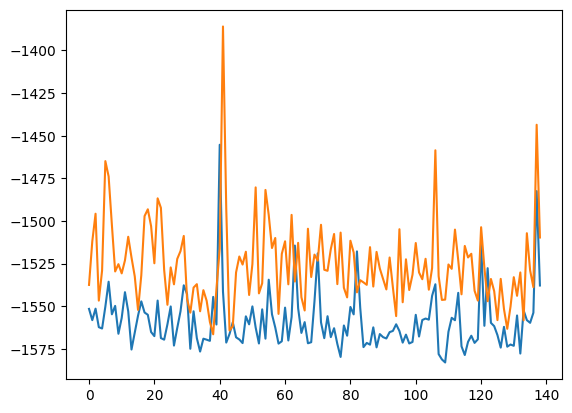

alpha 0.1 default_lr 0.0005


In [23]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [24]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [25]:
print(datetime.datetime.now())

2023-07-26 14:19:29.652980


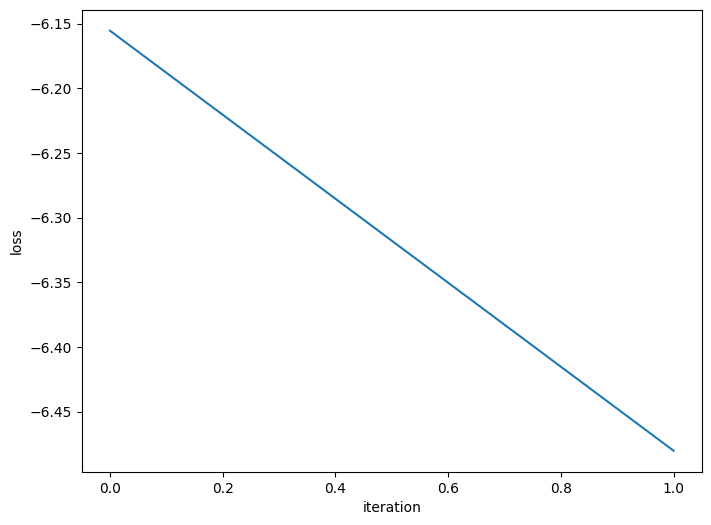

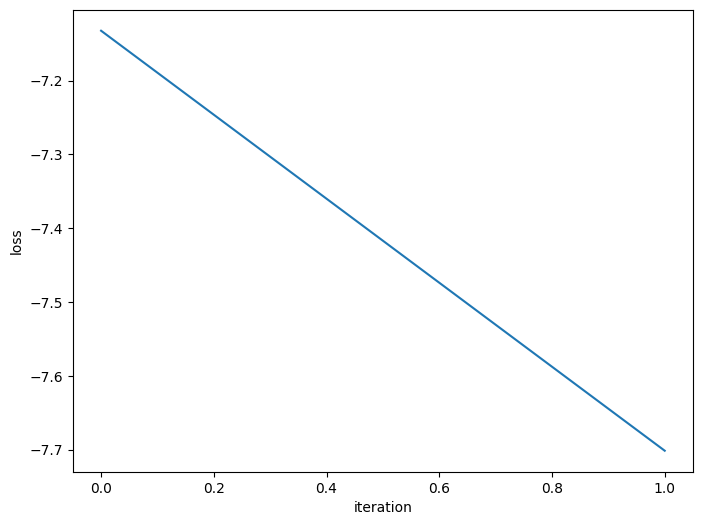

In [27]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [28]:
policy_evaluation_iter=2

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85
predict diverge [-7.87487575 -8.80724843 29.00378227  1.47645296] [-0.11783254 -0.32530108  0.03027319 -0.10526519] [17.259445  8.767078 53.96649  22.62447 ] [ 8.629723  4.383539 26.983246 11.312235] sim_timestep 160

 86

 87
predict diverge [ 5.06510812  8.82796449 -1.00305684 -0.09070331] [ 0.05169221  0.16256798 -0.018605   -0.04188764] [17.259445  8.767078 53.96649  22.62447 ] [ 8.629723  4.383539 26.983246 11.312235] sim_timestep 159

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.71435  validloss 0.72311±0.00000  bestvalidloss 0.72311  last_update 0
train: iter 1  trainloss 0.69171  validloss 0.69677±0.00000  bestvalidloss 0.69677  last_update 0
train: iter 2  trainloss 0.67998  validloss 0.72205±0.00000  bestvalidloss 0.69677  last_update 1
train: iter 3  trainloss 0.67922  validloss 0.70338±0.00000  bestvalidloss 0.69677  last_update 2
train: iter 4  trainloss 0.66977  validloss 0.68736±0.00000  bestvalidloss 0.68736  last_update 0
train: iter 5  trainloss 0.66359  validloss 0.69698±0.00000  bestvalidloss 0.68736  last_update 1
train: iter 6  trainloss 0.67073  validloss 0.69975±0.00000  bestvalidloss 0.68736  last_update 2
train: iter 7  trainloss 0.66347  validloss 0.69130±0.00000  bestvalidloss 0.68736  last_update 3
train: iter 8  trainloss 0.66103  validloss 0.70253±0.00000  bestvalidloss 0.68736  last_update 4
train: iter 9  trainloss 0.66177  validloss 0.71900±0.00000  bestvalidloss 0.68736  last_update 5
train: iter 10  trai

train: iter 83  trainloss 0.62254  validloss 0.70162±0.00000  bestvalidloss 0.68654  last_update 1
train: iter 84  trainloss 0.60910  validloss 0.67743±0.00000  bestvalidloss 0.67743  last_update 0
train: iter 85  trainloss 0.60685  validloss 0.70806±0.00000  bestvalidloss 0.67743  last_update 1
train: iter 86  trainloss 0.61388  validloss 0.70414±0.00000  bestvalidloss 0.67743  last_update 2
train: iter 87  trainloss 0.61606  validloss 0.69122±0.00000  bestvalidloss 0.67743  last_update 3
train: iter 88  trainloss 0.61643  validloss 0.70337±0.00000  bestvalidloss 0.67743  last_update 4
train: iter 89  trainloss 0.60978  validloss 0.69974±0.00000  bestvalidloss 0.67743  last_update 5
train: iter 90  trainloss 0.60833  validloss 0.69819±0.00000  bestvalidloss 0.67743  last_update 6
train: iter 91  trainloss 0.61186  validloss 0.69782±0.00000  bestvalidloss 0.67743  last_update 7
train: iter 92  trainloss 0.61142  validloss 0.70208±0.00000  bestvalidloss 0.67743  last_update 8
train: ite

train: iter 166  trainloss 0.59271  validloss 0.70348±0.00000  bestvalidloss 0.67743  last_update 82
train: iter 167  trainloss 0.58589  validloss 0.68459±0.00000  bestvalidloss 0.67743  last_update 83
train: iter 168  trainloss 0.58830  validloss 0.70422±0.00000  bestvalidloss 0.67743  last_update 84
train: iter 169  trainloss 0.58996  validloss 0.78980±0.00000  bestvalidloss 0.67743  last_update 85
train: iter 170  trainloss 0.59193  validloss 0.71321±0.00000  bestvalidloss 0.67743  last_update 86
train: iter 171  trainloss 0.59134  validloss 0.69241±0.00000  bestvalidloss 0.67743  last_update 87
train: iter 172  trainloss 0.58635  validloss 0.74002±0.00000  bestvalidloss 0.67743  last_update 88
train: iter 173  trainloss 0.58596  validloss 0.70548±0.00000  bestvalidloss 0.67743  last_update 89
train: iter 174  trainloss 0.58552  validloss 0.72577±0.00000  bestvalidloss 0.67743  last_update 90
train: iter 175  trainloss 0.58345  validloss 0.69915±0.00000  bestvalidloss 0.67743  last_

In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


train_loss:  -6.3347839759081594
valid_loss:  -6.960131076145172
weight_alpha 1.0 h_min_tilde -12.311983 ell_tilde -6.4598533959555615 kappa_tilde 0.0004133738770555361
train_loss:  -7.593557149457931
valid_loss:  -7.641763601684571
weight_alpha 0.1 h_min_tilde -12.311983 ell_tilde -7.603198439903258 kappa_tilde 0.00046083513655832144


In [32]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1516.66718  validloss -1527.91588±0.00000  bestvalidloss -1527.91588  last_update 0
train: iter 1  trainloss -1538.87053  validloss -1545.40531±0.00000  bestvalidloss -1545.40531  last_update 0
train: iter 2  trainloss -1550.60609  validloss -1552.61222±0.00000  bestvalidloss -1552.61222  last_update 0
train: iter 3  trainloss -1490.68454  validloss -1555.13785±0.00000  bestvalidloss -1555.13785  last_update 0
train: iter 4  trainloss -1495.04179  validloss -1479.29528±0.00000  bestvalidloss -1555.13785  last_update 1
train: iter 5  trainloss -1528.91565  validloss -1471.77459±0.00000  bestvalidloss -1555.13785  last_update 2
train: iter 6  trainloss -1531.95030  validloss -1511.33321±0.00000  bestvalidloss -1555.13785  last_update 3
train: iter 7  trainloss -1503.71254  validloss -1492.13929±0.00000  bestvalidloss -1555.13785  last_update 4
train: iter 8  trainloss -1533.81802  validloss -1526.28604±0.00000  bestva

train: iter 74  trainloss -1529.23827  validloss -1551.92552±0.00000  bestvalidloss -1575.82366  last_update 19
train: iter 75  trainloss -1546.35323  validloss -1563.85725±0.00000  bestvalidloss -1575.82366  last_update 20
train: iter 76  trainloss -1550.02302  validloss -1547.69854±0.00000  bestvalidloss -1575.82366  last_update 21
train: iter 77  trainloss -1551.43342  validloss -1532.83265±0.00000  bestvalidloss -1575.82366  last_update 22
train: iter 78  trainloss -1549.74952  validloss -1551.56637±0.00000  bestvalidloss -1575.82366  last_update 23
train: iter 79  trainloss -1521.96385  validloss -1529.28380±0.00000  bestvalidloss -1575.82366  last_update 24
train: iter 80  trainloss -1550.74136  validloss -1503.06757±0.00000  bestvalidloss -1575.82366  last_update 25
train: iter 81  trainloss -1536.48625  validloss -1548.03723±0.00000  bestvalidloss -1575.82366  last_update 26
train: iter 82  trainloss -1541.26238  validloss -1522.52870±0.00000  bestvalidloss -1575.82366  last_up

train: iter 147  trainloss -1548.05315  validloss -1496.24665±0.00000  bestvalidloss -1581.28380  last_update 39
train: iter 148  trainloss -1550.82993  validloss -1533.95450±0.00000  bestvalidloss -1581.28380  last_update 40
train: iter 149  trainloss -1551.11992  validloss -1513.77328±0.00000  bestvalidloss -1581.28380  last_update 41
train: iter 150  trainloss -1480.55333  validloss -1548.83038±0.00000  bestvalidloss -1581.28380  last_update 42
train: iter 151  trainloss -1532.86897  validloss -1559.68461±0.00000  bestvalidloss -1581.28380  last_update 43
train: iter 152  trainloss -1546.14130  validloss -1527.68242±0.00000  bestvalidloss -1581.28380  last_update 44
train: iter 153  trainloss -1553.65687  validloss -1551.37410±0.00000  bestvalidloss -1581.28380  last_update 45
train: iter 154  trainloss -1542.88988  validloss -1514.54621±0.00000  bestvalidloss -1581.28380  last_update 46
train: iter 155  trainloss -1520.86723  validloss -1534.30500±0.00000  bestvalidloss -1581.28380

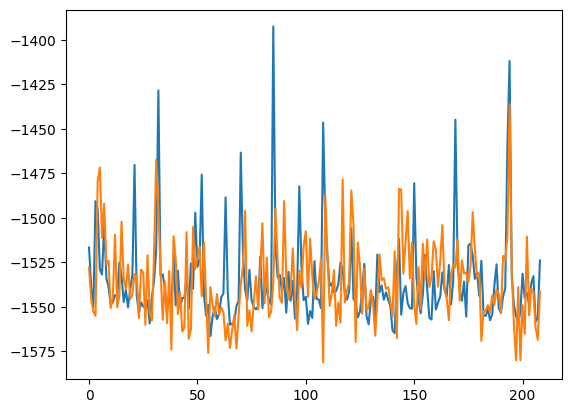

alpha 0.1 default_lr 0.0005


In [33]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [34]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [35]:
print(datetime.datetime.now())

2023-07-26 14:43:44.478873


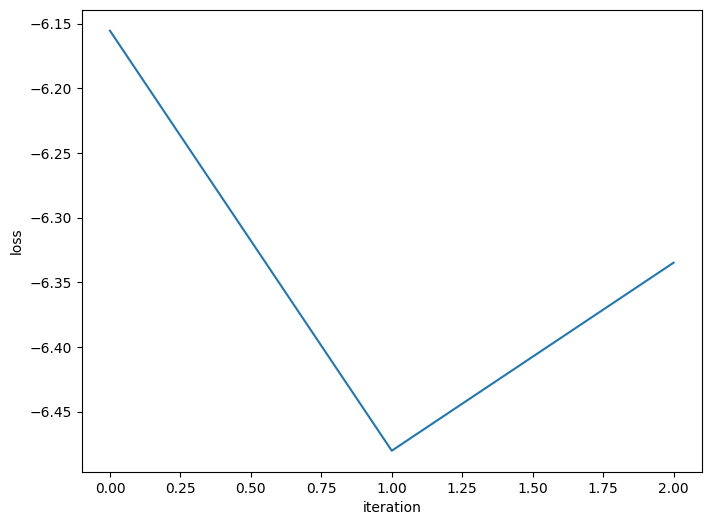

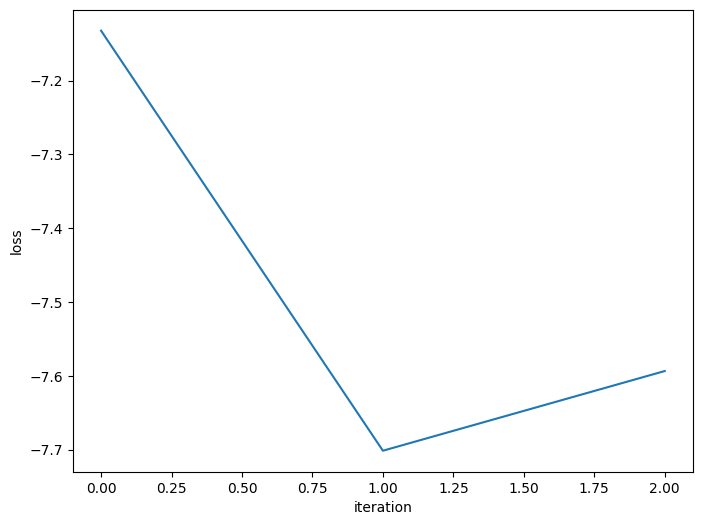

# Iter 4

In [37]:
policy_evaluation_iter=3

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22
predict diverge [2.17004488e-02 1.26641167e+01 1.26158861e+01 5.12082265e+01] [-0.04388466 13.14559967  0.2930003  32.52608924] [17.259445  8.767078 53.96649  22.62447 ] [ 8.629723  4.383539 26.983246 11.312235] sim_timestep 44

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.78496  validloss 0.82321±0.00000  bestvalidloss 0.82321  last_update 0
train: iter 1  trainloss 0.75683  validloss 0.76311±0.00000  bestvalidloss 0.76311  last_update 0
train: iter 2  trainloss 0.74030  validloss 0.72949±0.00000  bestvalidloss 0.72949  last_update 0
train: iter 3  trainloss 0.73481  validloss 0.70935±0.00000  bestvalidloss 0.70935  last_update 0
train: iter 4  trainloss 0.72101  validloss 0.73971±0.00000  bestvalidloss 0.70935  last_update 1
train: iter 5  trainloss 0.71622  validloss 0.70231±0.00000  bestvalidloss 0.70231  last_update 0
train: iter 6  trainloss 0.71336  validloss 0.70923±0.00000  bestvalidloss 0.70231  last_update 1
train: iter 7  trainloss 0.70408  validloss 0.71908±0.00000  bestvalidloss 0.70231  last_update 2
train: iter 8  trainloss 0.69633  validloss 0.71877±0.00000  bestvalidloss 0.70231  last_update 3
train: iter 9  trainloss 0.69437  validloss 0.71229±0.00000  bestvalidloss 0.70231  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.62145  validloss 0.69184±0.00000  bestvalidloss 0.68614  last_update 27
train: iter 84  trainloss 0.61979  validloss 0.69924±0.00000  bestvalidloss 0.68614  last_update 28
train: iter 85  trainloss 0.62186  validloss 0.70619±0.00000  bestvalidloss 0.68614  last_update 29
train: iter 86  trainloss 0.62649  validloss 0.69988±0.00000  bestvalidloss 0.68614  last_update 30
train: iter 87  trainloss 0.61697  validloss 0.69868±0.00000  bestvalidloss 0.68614  last_update 31
train: iter 88  trainloss 0.61435  validloss 0.71082±0.00000  bestvalidloss 0.68614  last_update 32
train: iter 89  trainloss 0.61684  validloss 0.68894±0.00000  bestvalidloss 0.68614  last_update 33
train: iter 90  trainloss 0.61346  validloss 0.68585±0.00000  bestvalidloss 0.68585  last_update 0
train: iter 91  trainloss 0.61541  validloss 0.69975±0.00000  bestvalidloss 0.68585  last_update 1
train: iter 92  trainloss 0.61140  validloss 0.69584±0.00000  bestvalidloss 0.68585  last_update 2
tra

train: iter 165  trainloss 0.58592  validloss 0.71819±0.00000  bestvalidloss 0.67791  last_update 44
train: iter 166  trainloss 0.58536  validloss 0.71985±0.00000  bestvalidloss 0.67791  last_update 45
train: iter 167  trainloss 0.58971  validloss 0.69975±0.00000  bestvalidloss 0.67791  last_update 46
train: iter 168  trainloss 0.58783  validloss 0.68951±0.00000  bestvalidloss 0.67791  last_update 47
train: iter 169  trainloss 0.58514  validloss 0.69349±0.00000  bestvalidloss 0.67791  last_update 48
train: iter 170  trainloss 0.58679  validloss 0.71376±0.00000  bestvalidloss 0.67791  last_update 49
train: iter 171  trainloss 0.58557  validloss 0.70506±0.00000  bestvalidloss 0.67791  last_update 50
train: iter 172  trainloss 0.58362  validloss 0.70649±0.00000  bestvalidloss 0.67791  last_update 51
train: iter 173  trainloss 0.58078  validloss 0.70525±0.00000  bestvalidloss 0.67791  last_update 52
train: iter 174  trainloss 0.58148  validloss 0.70613±0.00000  bestvalidloss 0.67791  last_

In [40]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

train_loss:  -5.751334214675427
valid_loss:  -7.483859795379639
weight_alpha 1.0 h_min_tilde -12.323365 ell_tilde -6.09783933081627 kappa_tilde 0.0004007854794429159
train_loss:  -7.6793850982666
valid_loss:  -7.635711032104493
weight_alpha 0.1 h_min_tilde -12.323365 ell_tilde -7.670650285034178 kappa_tilde 0.00046360357684074394


In [41]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1547.32820  validloss -1523.67840±0.00000  bestvalidloss -1523.67840  last_update 0
train: iter 1  trainloss -1518.75860  validloss -1577.64480±0.00000  bestvalidloss -1577.64480  last_update 0
train: iter 2  trainloss -1558.58012  validloss -1569.73429±0.00000  bestvalidloss -1577.64480  last_update 1
train: iter 3  trainloss -1572.27643  validloss -1570.58943±0.00000  bestvalidloss -1577.64480  last_update 2
train: iter 4  trainloss -1579.21944  validloss -1565.80609±0.00000  bestvalidloss -1577.64480  last_update 3
train: iter 5  trainloss -1549.15487  validloss -1561.08381±0.00000  bestvalidloss -1577.64480  last_update 4
train: iter 6  trainloss -1565.41035  validloss -1558.85093±0.00000  bestvalidloss -1577.64480  last_update 5
train: iter 7  trainloss -1566.45708  validloss -1555.77148±0.00000  bestvalidloss -1577.64480  last_update 6
train: iter 8  trainloss -1447.54269  validloss -1568.21938±0.00000  bestva

train: iter 74  trainloss -1547.31655  validloss -1553.58943±0.00000  bestvalidloss -1592.62097  last_update 46
train: iter 75  trainloss -1530.07649  validloss -1545.78735±0.00000  bestvalidloss -1592.62097  last_update 47
train: iter 76  trainloss -1489.91263  validloss -1557.47459±0.00000  bestvalidloss -1592.62097  last_update 48
train: iter 77  trainloss -1560.11619  validloss -1562.58130±0.00000  bestvalidloss -1592.62097  last_update 49
train: iter 78  trainloss -1567.15353  validloss -1579.33195±0.00000  bestvalidloss -1592.62097  last_update 50
train: iter 79  trainloss -1565.99725  validloss -1547.71721±0.00000  bestvalidloss -1592.62097  last_update 51
train: iter 80  trainloss -1566.75946  validloss -1558.63565±0.00000  bestvalidloss -1592.62097  last_update 52
train: iter 81  trainloss -1562.64034  validloss -1537.39208±0.00000  bestvalidloss -1592.62097  last_update 53
train: iter 82  trainloss -1540.18559  validloss -1523.86071±0.00000  bestvalidloss -1592.62097  last_up

train: iter 147  trainloss -1570.92442  validloss -1551.03178±0.00000  bestvalidloss -1595.47718  last_update 53
train: iter 148  trainloss -1537.43948  validloss -1579.91495±0.00000  bestvalidloss -1595.47718  last_update 54
train: iter 149  trainloss -1564.73767  validloss -1530.68969±0.00000  bestvalidloss -1595.47718  last_update 55
train: iter 150  trainloss -1578.69445  validloss -1551.31830±0.00000  bestvalidloss -1595.47718  last_update 56
train: iter 151  trainloss -1555.62840  validloss -1557.94330±0.00000  bestvalidloss -1595.47718  last_update 57
train: iter 152  trainloss -1354.18088  validloss -1541.08785±0.00000  bestvalidloss -1595.47718  last_update 58
train: iter 153  trainloss -1438.60942  validloss -1468.38819±0.00000  bestvalidloss -1595.47718  last_update 59
train: iter 154  trainloss -1521.19280  validloss -1519.77580±0.00000  bestvalidloss -1595.47718  last_update 60
train: iter 155  trainloss -1549.16078  validloss -1541.94269±0.00000  bestvalidloss -1595.47718

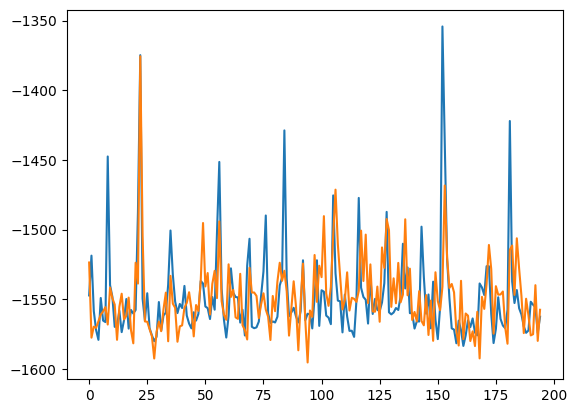

alpha 0.1 default_lr 0.0005


In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [43]:
print(datetime.datetime.now())

2023-07-26 15:07:51.119982


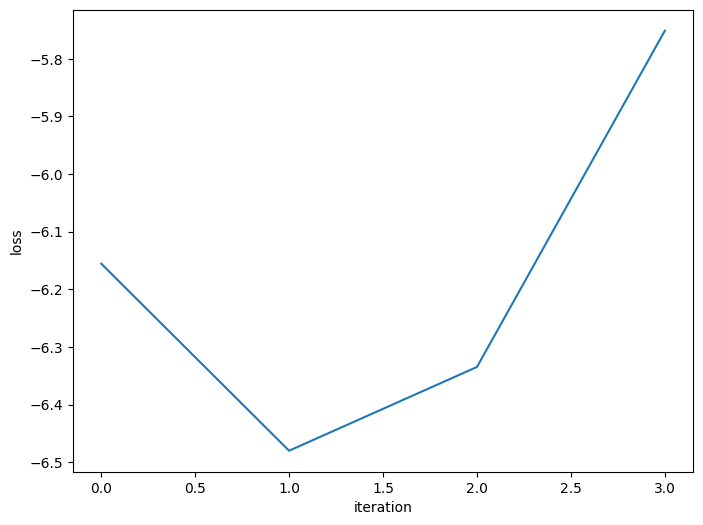

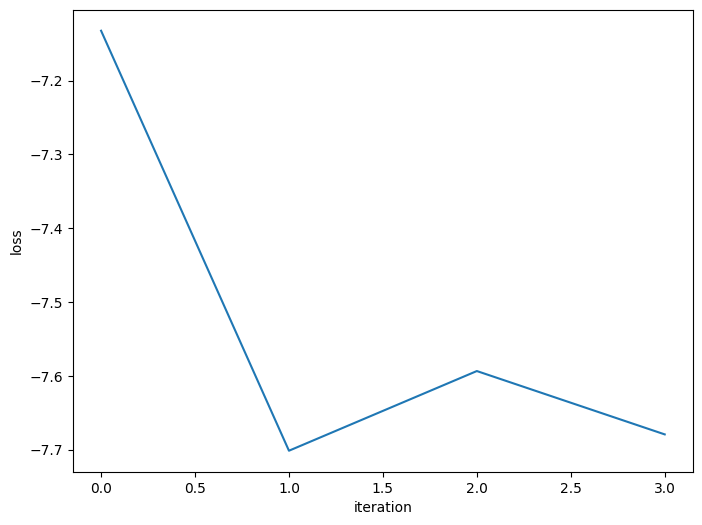

# Iter 5

In [45]:
policy_evaluation_iter=4

In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22
predict diverge [-1.78790233 -4.88998502 11.95159202 29.26842502] [-0.06944696  0.08219799  0.25829539 10.30837192] [17.259445  8.767078 53.96649  22.62447 ] [ 8.629723  4.383539 26.983246 11.312235] sim_timestep 59

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [47]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.66437  validloss 0.67003±0.00000  bestvalidloss 0.67003  last_update 0
train: iter 1  trainloss 0.63801  validloss 0.68231±0.00000  bestvalidloss 0.67003  last_update 1
train: iter 2  trainloss 0.63540  validloss 0.66084±0.00000  bestvalidloss 0.66084  last_update 0
train: iter 3  trainloss 0.63333  validloss 0.66619±0.00000  bestvalidloss 0.66084  last_update 1
train: iter 4  trainloss 0.62410  validloss 0.65778±0.00000  bestvalidloss 0.65778  last_update 0
train: iter 5  trainloss 0.62439  validloss 0.65701±0.00000  bestvalidloss 0.65701  last_update 0
train: iter 6  trainloss 0.61921  validloss 0.65833±0.00000  bestvalidloss 0.65701  last_update 1
train: iter 7  trainloss 0.62235  validloss 0.65056±0.00000  bestvalidloss 0.65056  last_update 0
train: iter 8  trainloss 0.61571  validloss 0.64824±0.00000  bestvalidloss 0.64824  last_update 0
train: iter 9  trainloss 0.61724  validloss 0.68009±0.00000  bestvalidloss 0.64824  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.57278  validloss 0.64499±0.00000  bestvalidloss 0.63437  last_update 69
train: iter 84  trainloss 0.57278  validloss 0.64964±0.00000  bestvalidloss 0.63437  last_update 70
train: iter 85  trainloss 0.57131  validloss 0.64391±0.00000  bestvalidloss 0.63437  last_update 71
train: iter 86  trainloss 0.57172  validloss 0.64836±0.00000  bestvalidloss 0.63437  last_update 72
train: iter 87  trainloss 0.57170  validloss 0.63881±0.00000  bestvalidloss 0.63437  last_update 73
train: iter 88  trainloss 0.56997  validloss 0.64658±0.00000  bestvalidloss 0.63437  last_update 74
train: iter 89  trainloss 0.57321  validloss 0.65645±0.00000  bestvalidloss 0.63437  last_update 75
train: iter 90  trainloss 0.57174  validloss 0.64648±0.00000  bestvalidloss 0.63437  last_update 76
train: iter 91  trainloss 0.56301  validloss 0.64640±0.00000  bestvalidloss 0.63437  last_update 77
train: iter 92  trainloss 0.56746  validloss 0.64390±0.00000  bestvalidloss 0.63437  last_update 78


In [48]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

train_loss:  -5.125423810034991
valid_loss:  -6.8028322183609005
weight_alpha 1.0 h_min_tilde -12.324062 ell_tilde -5.460905491700173 kappa_tilde 0.00038171395511691454
train_loss:  -7.336666311264038
valid_loss:  -7.203695211791993
weight_alpha 0.1 h_min_tilde -12.324062 ell_tilde -7.31007209136963 kappa_tilde 0.00044658924215368166


In [49]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1461.43305  validloss -1446.27192±0.00000  bestvalidloss -1446.27192  last_update 0
train: iter 1  trainloss -1461.47229  validloss -1512.01040±0.00000  bestvalidloss -1512.01040  last_update 0
train: iter 2  trainloss -1478.37663  validloss -1482.71518±0.00000  bestvalidloss -1512.01040  last_update 1
train: iter 3  trainloss -1500.62990  validloss -1501.71360±0.00000  bestvalidloss -1512.01040  last_update 2
train: iter 4  trainloss -1491.74753  validloss -1512.31094±0.00000  bestvalidloss -1512.31094  last_update 0
train: iter 5  trainloss -1487.49993  validloss -1506.18750±0.00000  bestvalidloss -1512.31094  last_update 1
train: iter 6  trainloss -1494.75326  validloss -1510.62662±0.00000  bestvalidloss -1512.31094  last_update 2
train: iter 7  trainloss -1488.51148  validloss -1504.25201±0.00000  bestvalidloss -1512.31094  last_update 3
train: iter 8  trainloss -1477.95411  validloss -1493.44782±0.00000  bestva

train: iter 74  trainloss -1489.14896  validloss -1489.75163±0.00000  bestvalidloss -1517.49887  last_update 38
train: iter 75  trainloss -1482.43562  validloss -1501.15390±0.00000  bestvalidloss -1517.49887  last_update 39
train: iter 76  trainloss -1473.32594  validloss -1514.75742±0.00000  bestvalidloss -1517.49887  last_update 40
train: iter 77  trainloss -1496.18548  validloss -1494.34030±0.00000  bestvalidloss -1517.49887  last_update 41
train: iter 78  trainloss -1494.97007  validloss -1488.35680±0.00000  bestvalidloss -1517.49887  last_update 42
train: iter 79  trainloss -1493.54112  validloss -1476.30522±0.00000  bestvalidloss -1517.49887  last_update 43
train: iter 80  trainloss -1495.45776  validloss -1500.84189±0.00000  bestvalidloss -1517.49887  last_update 44
train: iter 81  trainloss -1492.37973  validloss -1486.37484±0.00000  bestvalidloss -1517.49887  last_update 45
train: iter 82  trainloss -1482.00492  validloss -1486.33574±0.00000  bestvalidloss -1517.49887  last_up

train: iter 147  trainloss -1484.75527  validloss -1436.65508±0.00000  bestvalidloss -1518.41116  last_update 55
train: iter 148  trainloss -1486.82193  validloss -1435.48778±0.00000  bestvalidloss -1518.41116  last_update 56
train: iter 149  trainloss -1469.81578  validloss -1364.04248±0.00000  bestvalidloss -1518.41116  last_update 57
train: iter 150  trainloss -1477.55961  validloss -1465.00870±0.00000  bestvalidloss -1518.41116  last_update 58
train: iter 151  trainloss -1476.23563  validloss -1444.00735±0.00000  bestvalidloss -1518.41116  last_update 59
train: iter 152  trainloss -1471.54102  validloss -1403.03692±0.00000  bestvalidloss -1518.41116  last_update 60
train: iter 153  trainloss -1488.21849  validloss -1440.78655±0.00000  bestvalidloss -1518.41116  last_update 61
train: iter 154  trainloss -1483.37807  validloss -1479.56152±0.00000  bestvalidloss -1518.41116  last_update 62
train: iter 155  trainloss -1464.90449  validloss -1476.62438±0.00000  bestvalidloss -1518.41116

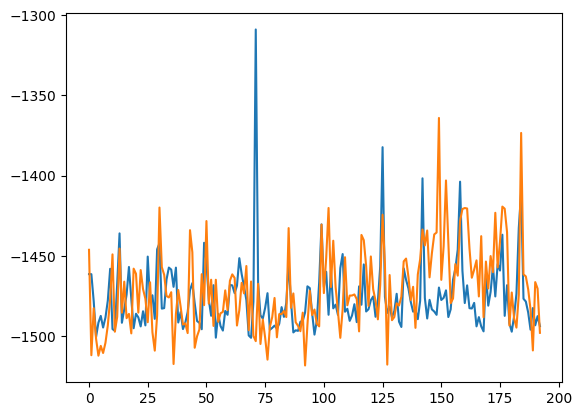

alpha 0.1 default_lr 0.0005


In [50]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [51]:
print(datetime.datetime.now())

2023-07-26 15:30:07.242601


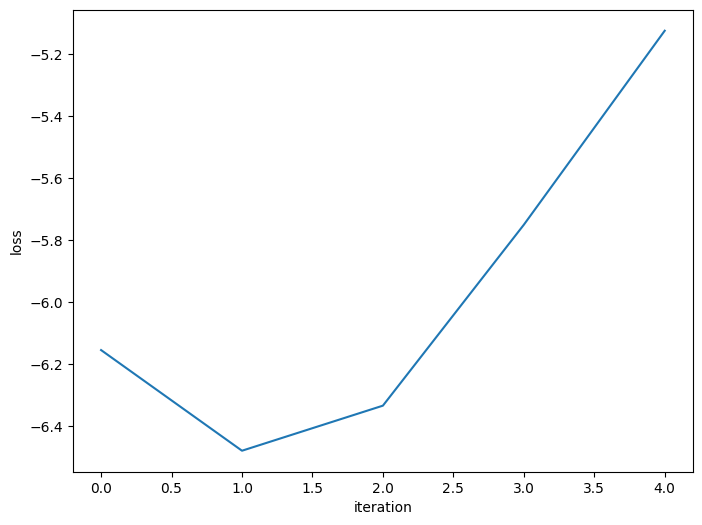

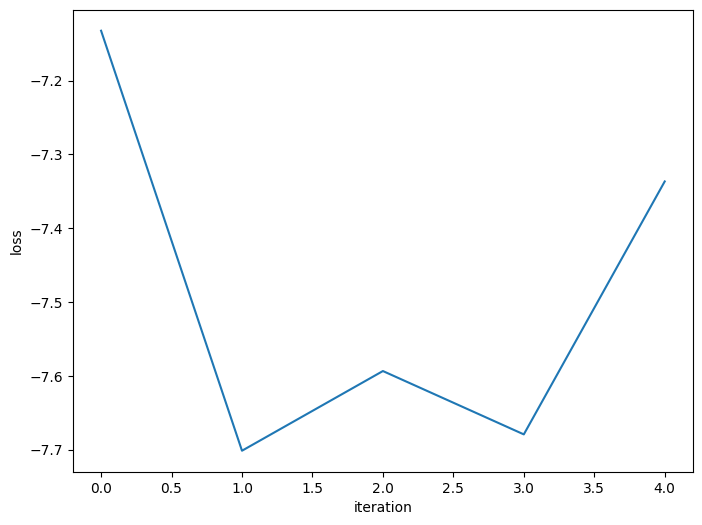

# 評価関数計算

In [53]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45
predict diverge [  3.79269898  -4.7657443  -16.55110398 -23.85040386] [-0.11583977 -0.07971617 -0.39923109 -4.04023016] [17.259445  8.767078 53.96649  22.62447 ] [ 8.629723  4.383539 26.983246 11.312235] sim_timestep 174

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82
predict diverge [  3.92571479  -5.92730957 -20.5331396  -22.84517303] [-0.06978258 -0.96337472 -0.37387992 -4.19247908] [17.259445  8.767078 53.96649  22.62447 ] [ 8.629723  4.383539 26.983246 11.312235] sim_timestep 182

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [54]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.70569  validloss 0.75291±0.00000  bestvalidloss 0.75291  last_update 0
train: iter 1  trainloss 0.67015  validloss 0.74454±0.00000  bestvalidloss 0.74454  last_update 0
train: iter 2  trainloss 0.66031  validloss 0.74829±0.00000  bestvalidloss 0.74454  last_update 1
train: iter 3  trainloss 0.64712  validloss 0.73541±0.00000  bestvalidloss 0.73541  last_update 0
train: iter 4  trainloss 0.64367  validloss 0.72541±0.00000  bestvalidloss 0.72541  last_update 0
train: iter 5  trainloss 0.63956  validloss 0.72155±0.00000  bestvalidloss 0.72155  last_update 0
train: iter 6  trainloss 0.63292  validloss 0.72654±0.00000  bestvalidloss 0.72155  last_update 1
train: iter 7  trainloss 0.62788  validloss 0.72298±0.00000  bestvalidloss 0.72155  last_update 2
train: iter 8  trainloss 0.62411  validloss 0.73066±0.00000  bestvalidloss 0.72155  last_update 3
train: iter 9  trainloss 0.62321  validloss 0.72963±0.00000  bestvalidloss 0.72155  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.56664  validloss 0.71105±0.00000  bestvalidloss 0.70329  last_update 19
train: iter 84  trainloss 0.57925  validloss 0.71197±0.00000  bestvalidloss 0.70329  last_update 20
train: iter 85  trainloss 0.56680  validloss 0.71814±0.00000  bestvalidloss 0.70329  last_update 21
train: iter 86  trainloss 0.56665  validloss 0.73577±0.00000  bestvalidloss 0.70329  last_update 22
train: iter 87  trainloss 0.56777  validloss 0.71982±0.00000  bestvalidloss 0.70329  last_update 23
train: iter 88  trainloss 0.56692  validloss 0.72125±0.00000  bestvalidloss 0.70329  last_update 24
train: iter 89  trainloss 0.56866  validloss 0.72252±0.00000  bestvalidloss 0.70329  last_update 25
train: iter 90  trainloss 0.56074  validloss 0.71694±0.00000  bestvalidloss 0.70329  last_update 26
train: iter 91  trainloss 0.56196  validloss 0.73107±0.00000  bestvalidloss 0.70329  last_update 27
train: iter 92  trainloss 0.56476  validloss 0.70961±0.00000  bestvalidloss 0.70329  last_update 28


([0.7056860844604671,
  0.6701457917690277,
  0.6603050889447332,
  0.6471156300976872,
  0.64366624802351,
  0.6395625956356525,
  0.6329171316698193,
  0.6278803989291191,
  0.6241094073280692,
  0.6232067536562681,
  0.6216332150623203,
  0.6234009543433785,
  0.6133205559104681,
  0.617588615976274,
  0.6180633120238781,
  0.6159519230946898,
  0.6072465095669031,
  0.6046701487153768,
  0.6027695458382368,
  0.6061974484473467,
  0.6028094816952944,
  0.5983253520913422,
  0.6067692544311285,
  0.5966201872564852,
  0.6019236341118812,
  0.6062536629848182,
  0.6000124016776681,
  0.5971910933032631,
  0.597810163255781,
  0.5987233994528651,
  0.6011520358733833,
  0.5915353715419769,
  0.5920767724514008,
  0.5913288450799883,
  0.5945574845187366,
  0.5876523273065686,
  0.5922812935896218,
  0.5907307641580701,
  0.5904351346194744,
  0.589486095868051,
  0.5896267860196531,
  0.5920069625601172,
  0.5844795221462846,
  0.5821062247268856,
  0.584708753041923,
  0.582407914474

In [55]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.735467057299614
valid_loss:  -7.41180557346344
weight_alpha 1.0 h_min_tilde -12.324005 ell_tilde -6.07073476053238 kappa_tilde 0.0003998953893265749
train_loss:  -7.680243330001832
valid_loss:  -7.4605184936523425
weight_alpha 0.1 h_min_tilde -12.324005 ell_tilde -7.636298362731934 kappa_tilde 0.00046187002898970004


In [56]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 10.07573  validloss 10.15551±0.00000  bestvalidloss 10.15551  last_update 0
train: iter 1  trainloss 7.90067  validloss 7.63833±0.00000  bestvalidloss 7.63833  last_update 0
train: iter 2  trainloss 6.23765  validloss 5.91184±0.00000  bestvalidloss 5.91184  last_update 0
train: iter 3  trainloss 4.97717  validloss 4.50988±0.00000  bestvalidloss 4.50988  last_update 0
train: iter 4  trainloss 3.96762  validloss 3.38625±0.00000  bestvalidloss 3.38625  last_update 0
train: iter 5  trainloss 3.23497  validloss 2.57515±0.00000  bestvalidloss 2.57515  last_update 0
train: iter 6  trainloss 2.55035  validloss 1.93362±0.00000  bestvalidloss 1.93362  last_update 0
train: iter 7  trainloss 2.11428  validloss 1.40071±0.00000  bestvalidloss 1.40071  last_update 0
train: iter 8  trainloss 1.74700  validloss 1.10965±0.00000  bestvalidloss 1.10965  last_update 0
train: iter 9  trainloss 1.49102  validloss 0.76978±0.00000  bestvalidloss 0.76978  last_update 0
train: iter 10  t

train: iter 86  trainloss 0.25225  validloss -0.34689±0.00000  bestvalidloss -0.41621  last_update 64
train: iter 87  trainloss 0.24661  validloss -0.34042±0.00000  bestvalidloss -0.41621  last_update 65
train: iter 88  trainloss 0.22807  validloss -0.31471±0.00000  bestvalidloss -0.41621  last_update 66
train: iter 89  trainloss 0.24455  validloss -0.32481±0.00000  bestvalidloss -0.41621  last_update 67
train: iter 90  trainloss 0.25652  validloss -0.30813±0.00000  bestvalidloss -0.41621  last_update 68
train: iter 91  trainloss 0.26315  validloss -0.30594±0.00000  bestvalidloss -0.41621  last_update 69
train: iter 92  trainloss 0.25812  validloss -0.32113±0.00000  bestvalidloss -0.41621  last_update 70
train: iter 93  trainloss 0.25364  validloss -0.33846±0.00000  bestvalidloss -0.41621  last_update 71
train: iter 94  trainloss 0.26029  validloss -0.30615±0.00000  bestvalidloss -0.41621  last_update 72
train: iter 95  trainloss 0.25893  validloss -0.32294±0.00000  bestvalidloss -0.41

In [57]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-1.2660, -0.4339, -2.8124, -2.6274], requires_grad=True)


In [58]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 7.70735  validloss 46.34069±0.00000  bestvalidloss 46.34069  last_update 0
train: iter 1  trainloss 1.60819  validloss 8.87568±0.00000  bestvalidloss 8.87568  last_update 0
train: iter 2  trainloss 1.62595  validloss 10.25515±0.00000  bestvalidloss 8.87568  last_update 1
train: iter 3  trainloss 1.59310  validloss 10.59236±0.00000  bestvalidloss 8.87568  last_update 2
train: iter 4  trainloss 1.60097  validloss 10.93957±0.00000  bestvalidloss 8.87568  last_update 3
train: iter 5  trainloss 1.55767  validloss 10.08555±0.00000  bestvalidloss 8.87568  last_update 4
train: iter 6  trainloss 1.57102  validloss 9.75829±0.00000  bestvalidloss 8.87568  last_update 5
train: iter 7  trainloss 1.51861  validloss 9.63639±0.00000  bestvalidloss 8.87568  last_update 6
train: iter 8  trainloss 1.62503  validloss 9.33701±0.00000  bestvalidloss 8.87568  last_update 7
train: iter 9  trainloss 1.54874  validloss 9.78247±0.00000  bestvalidloss 8.87568  last_update 8
train: iter 10

train: iter 83  trainloss 1.52555  validloss 10.07113±0.00000  bestvalidloss 8.14576  last_update 56
train: iter 84  trainloss 1.47812  validloss 8.30029±0.00000  bestvalidloss 8.14576  last_update 57
train: iter 85  trainloss 1.48780  validloss 9.21462±0.00000  bestvalidloss 8.14576  last_update 58
train: iter 86  trainloss 1.48090  validloss 10.01256±0.00000  bestvalidloss 8.14576  last_update 59
train: iter 87  trainloss 1.50697  validloss 9.36825±0.00000  bestvalidloss 8.14576  last_update 60
train: iter 88  trainloss 1.49964  validloss 9.72101±0.00000  bestvalidloss 8.14576  last_update 61
train: iter 89  trainloss 1.46383  validloss 8.73220±0.00000  bestvalidloss 8.14576  last_update 62
train: iter 90  trainloss 1.44562  validloss 9.94624±0.00000  bestvalidloss 8.14576  last_update 63
train: iter 91  trainloss 1.45507  validloss 9.93587±0.00000  bestvalidloss 8.14576  last_update 64
train: iter 92  trainloss 1.46556  validloss 9.33070±0.00000  bestvalidloss 8.14576  last_update 6

In [59]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-7.1397)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(7.0516)


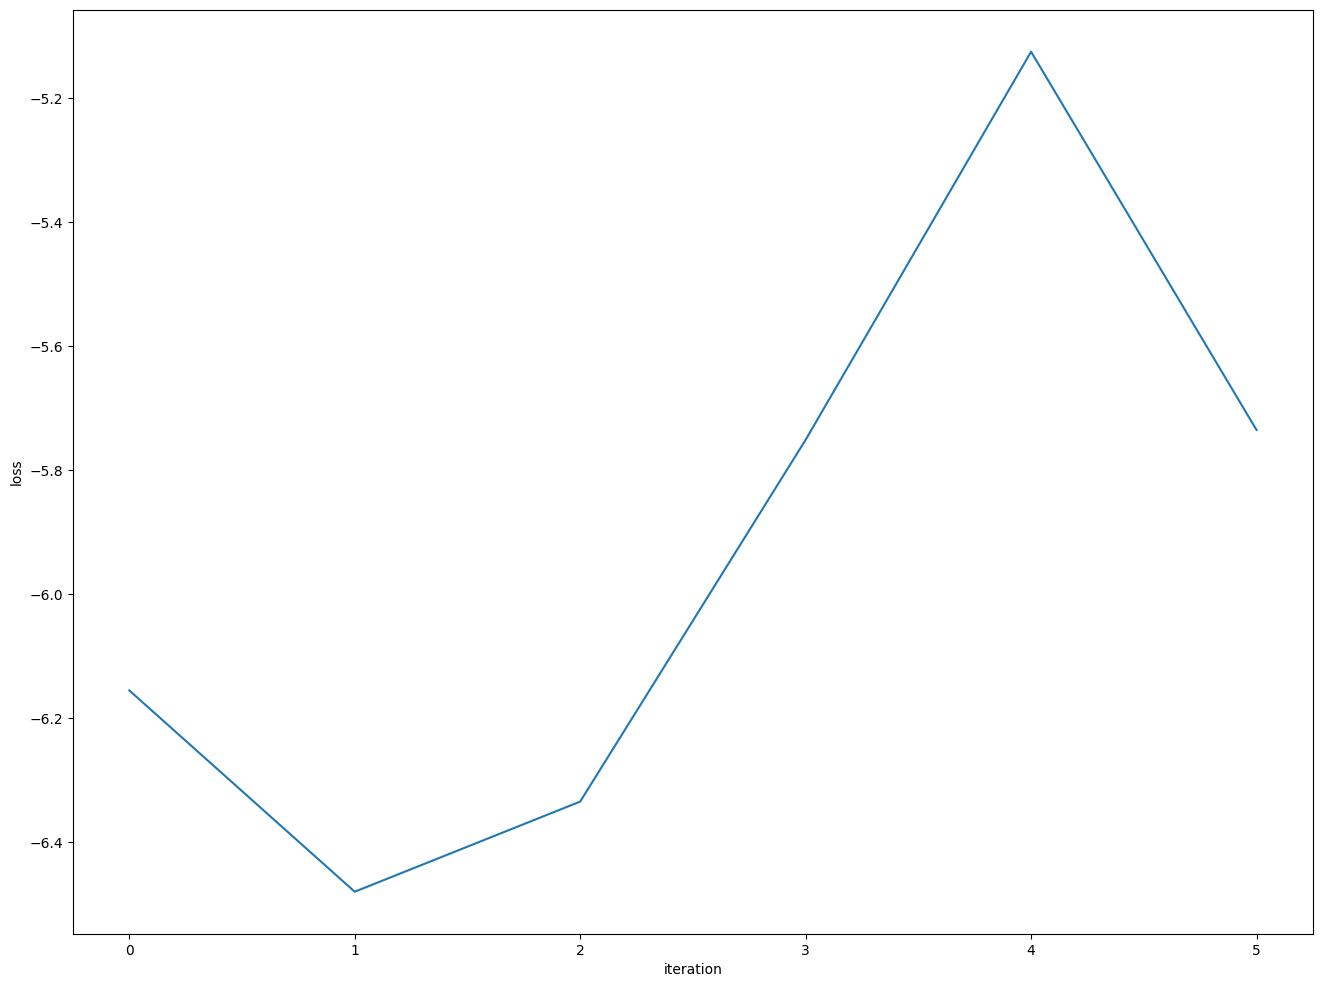

In [60]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

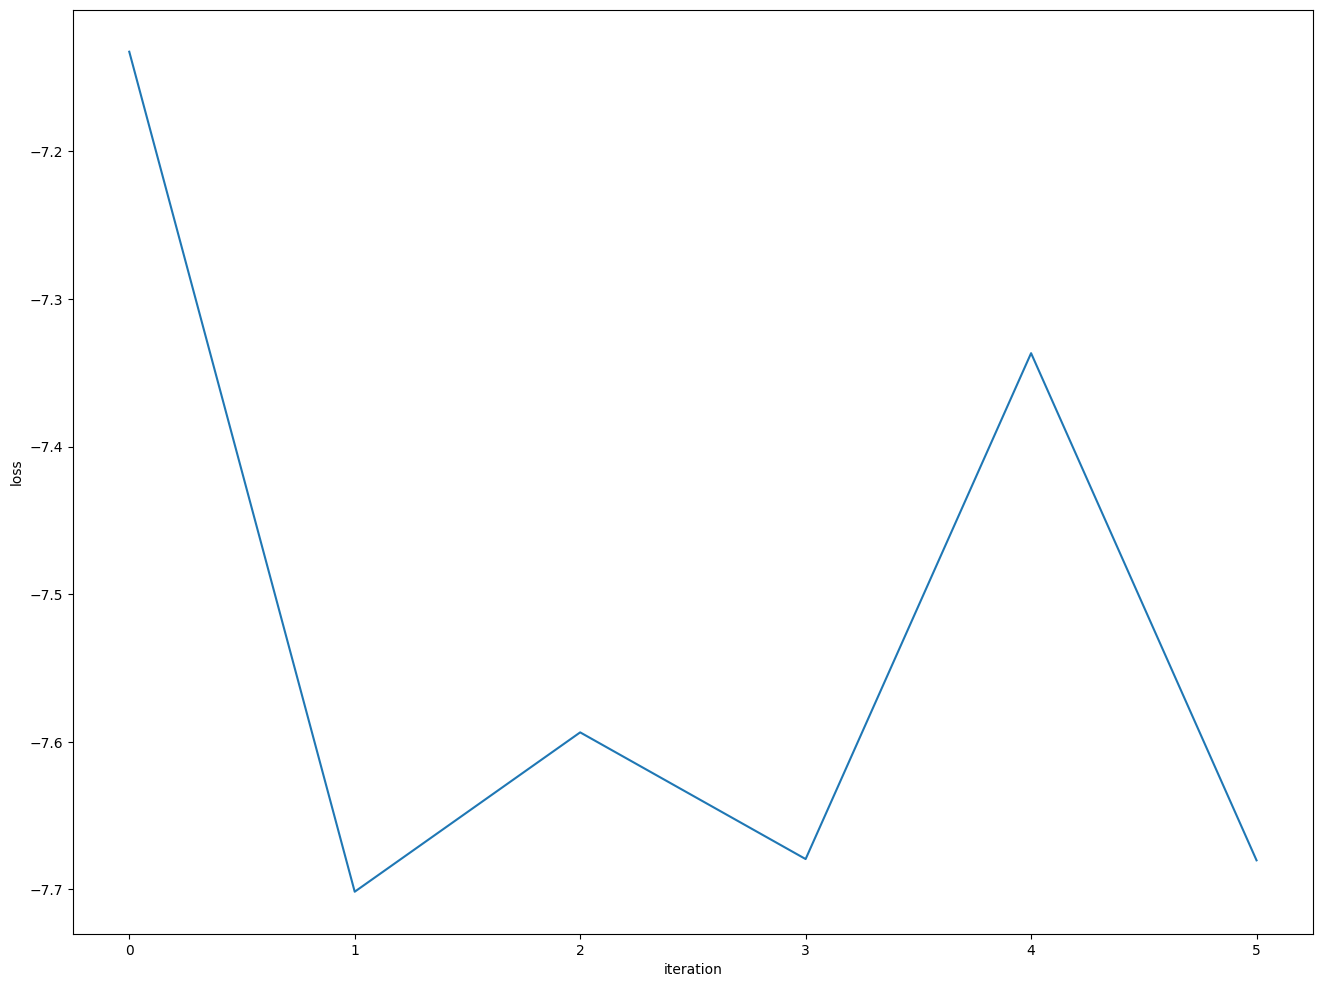

In [61]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")